## Objective
Make RT-Sort spike assignment very fast

3 --> 3_tuning: Tuning spike assignment thresholds with CometML

## Setup

### Notebook and recording

In [1]:
%load_ext autoreload

In [2]:
from math import ceil
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt
import torch

torch.backends.cudnn.benchmark = True

from tqdm import tqdm

%autoreload 2
from src import utils

In [3]:
TRACES = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/traces.npy", mmap_mode="r")
OUTPUTS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/outputs.npy", mmap_mode="r")
ELEC_LOCS = np.load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/elec_locs.npy", mmap_mode="r")
ALL_SEQUENCES = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/ground_truth_sequences.pickle")
# ALL_SEQUENCES = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/230113/merged_sequences.pickle")

In [4]:
SAMP_FREQ = 32  # kHz
FRONT_BUFFER = 60
N_BEFORE = N_AFTER = round(0.5 * SAMP_FREQ)

In [5]:
START_FRAME = 0
END_FRAME = round(5*60*1000*SAMP_FREQ)+1

TORCH_TRACES = torch.tensor(TRACES[:, START_FRAME:END_FRAME], dtype=torch.float16, device="cuda")
TORCH_OUTPUTS = torch.tensor(OUTPUTS[:, START_FRAME:END_FRAME], dtype=torch.float16, device="cuda")

In [ ]:
elec_to_seqs = {}
for seq in ALL_SEQUENCES:
    if seq.root_elec not in elec_to_seqs:
        elec_to_seqs[seq.root_elec] = [seq]
    else:
        elec_to_seqs[seq.root_elec].append(seq)

In [ ]:
for seq in elec_to_seqs[184]:
    print(seq.idx, seq.comp_elecs)
print()
for seq in elec_to_seqs[301]:
    print(seq.idx, seq.comp_elecs)

1 [184, 89, 280, 376, 281, 88]
49 [184, 88, 89, 281]

4 [301, 109, 205, 206]
85 [301, 12, 13, 14, 15, 299, 300, 302, 303, 304, 203, 204, 205, 206, 207, 208, 107, 108, 109, 110, 111]


In [44]:
def sigmoid(x):
    exp = np.exp(x)
    return exp / (1 + exp)

def sigmoid_inverse(y):
    return -np.log(1 / y - 1)

def calc_elec_dist(elec1, elec2):
    # Calculate the spatial distance between two electrodes
    x1, y1 = ELEC_LOCS[elec1]
    x2, y2 = ELEC_LOCS[elec2]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# root_elec = 0
STRICT_THRESH_LOGIT = sigmoid_inverse(0.1)# -1.7346010553881064
LOOSE_THRESH_LOGIT = -2.1972245773362196

MIN_LOOSE_DETECTIONS_N = 3 
MIN_LOOSE_DETECTIONS_R = 2/3
MIN_INNER_LOOSE_DETECTIONS = 2

CLIP_LATENCY_DIFF = 5
CLIP_AMP_DIFF = 1

MAX_LATENCY_DIFF_SPIKES = 3#2.5
MAX_AMP_MEDIAN_DIFF_SPIKES = 0.35
MAX_ROOT_AMP_MEDIAN_STD = 2

MAX_LOOSE_DETECTIONS = round(0.5 * TRACES.shape[0])

OVERLAP = round(0.2 * SAMP_FREQ)
INNER_RADIUS = 50
OUTER_RADIUS = 100

PRE_MEDIAN_FRAMES = round(50*SAMP_FREQ)

In [7]:
OUTPUT_WINDOW_HALF_SIZE = 90 #3 * SAMP_FREQ

### Sequences

In [8]:
# Setup
all_sequences = ALL_SEQUENCES# elec_to_seqs[184] + elec_to_seqs[301]
# all_sequences = [ALL_SEQUENCES[4], ALL_SEQUENCES[5]]
num_seqs = len(all_sequences)

all_comp_elecs = set()
seq_n_before = -np.inf
seq_n_after = -np.inf
seq_no_overlap_mask = torch.full((num_seqs, num_seqs), 0, dtype=torch.bool, device="cuda")
seq_idx_to_outer_elecs = {}
for a, seq in enumerate(all_sequences):
    all_comp_elecs.update(seq.comp_elecs)
    seq_n_before = max(seq_n_before, ceil(np.abs(np.min(seq.all_latencies[seq.comp_elecs]))) + CLIP_LATENCY_DIFF)
    seq_n_after = max(seq_n_after, ceil(np.abs(np.max(seq.all_latencies[seq.comp_elecs]))) + CLIP_LATENCY_DIFF)
    for b, seq_b in enumerate(all_sequences):
        if calc_elec_dist(seq.root_elec, seq_b.root_elec) > INNER_RADIUS:
            seq_no_overlap_mask[a, b] = 1
    outer_elecs = []
    for elec in range(len(ELEC_LOCS)):
        if calc_elec_dist(seq.root_elec, elec) <= OUTER_RADIUS:
            outer_elecs.append(elec)
    seq_idx_to_outer_elecs[a] = outer_elecs

all_comp_elecs = list(all_comp_elecs)
spike_arange = torch.arange(0, seq_n_before+seq_n_after+1, device="cuda")

seqs_root_elecs = set()
seqs_root_elecs_dups = []  # Allow for multiple copies of same root elecs
seqs_root_elecs_rel_comp_elecs = []
seqs_inner_loose_elecs = []
seqs_min_loose_elecs = []
seqs_loose_elecs = []
seqs_latencies = []
seqs_latency_weights = []
seqs_amps = []
seqs_root_amp_means = []
seqs_root_amp_stds = []
seqs_amp_weights = []
for seq in all_sequences: 
    seqs_root_elecs.add(seq.root_elec)
    seqs_root_elecs_dups.append(seq.root_elec)
    seqs_root_elecs_rel_comp_elecs.append(all_comp_elecs.index(seq.root_elec))

    # Binary arrays (1 for comp_elec in inner_loose_elecs/loose_elecs, else 0)
    seqs_inner_loose_elecs.append(torch.tensor([1 if elec in seq.inner_loose_elecs else 0 for elec in all_comp_elecs], dtype=torch.bool, device="cuda"))
    seqs_loose_elecs.append(torch.tensor([1 if elec in seq.loose_elecs else 0 for elec in all_comp_elecs], dtype=torch.bool, device="cuda"))
    
    seqs_min_loose_elecs.append(ceil(seq.min_loose_detections))
    
    seq_comp_elecs = set(seq.comp_elecs)
    seqs_latencies.append(torch.tensor([seq.all_latencies[elec] + seq_n_before if elec in seq_comp_elecs and elec != seq.root_elec else 0 for elec in all_comp_elecs], dtype=torch.float16, device="cuda"))
    seqs_amps.append(torch.tensor([seq.all_amp_medians[elec] if elec in seq_comp_elecs else 1 for elec in all_comp_elecs], dtype=torch.float16, device="cuda"))  # Needs to be 1 to prevent divide by zero
    
    elec_probs = torch.tensor([seq.all_elec_probs[elec] if elec in seq_comp_elecs and elec != seq.root_elec else 0 for elec in all_comp_elecs], dtype=torch.float16, device="cuda")
    seqs_latency_weights.append(elec_probs/torch.sum(elec_probs))
    
    elec_probs = torch.tensor([seq.all_elec_probs[elec] if elec in seq_comp_elecs else 0 for elec in all_comp_elecs], dtype=torch.float16, device="cuda")
    seqs_amp_weights.append(elec_probs/torch.sum(elec_probs))
    
    seqs_root_amp_means.append(seq.all_amp_medians[seq.root_elec])
    seqs_root_amp_stds.append(seq.root_to_amp_median_std[seq.root_elec])
    
comp_elecs = torch.tensor(all_comp_elecs, dtype=torch.long, device="cuda")[:, None]
comp_elecs_flattened = comp_elecs.flatten()
    
seqs_root_elecs = list(seqs_root_elecs)
    
seqs_inner_loose_elecs = torch.vstack(seqs_inner_loose_elecs)
seqs_loose_elecs = torch.vstack(seqs_loose_elecs)
seqs_min_loose_elecs = torch.tensor(seqs_min_loose_elecs, dtype=torch.int16, device="cuda")
seqs_latencies = torch.vstack(seqs_latencies)
seqs_amps = torch.vstack(seqs_amps)
seqs_latency_weights = torch.vstack(seqs_latency_weights)
seqs_amp_weights = torch.vstack(seqs_amp_weights)
seqs_root_amp_means = torch.tensor(seqs_root_amp_means, dtype=torch.float16, device="cuda")
seqs_root_amp_stds = torch.tensor(seqs_root_amp_stds, dtype=torch.float16, device="cuda")
    
max_pool = torch.nn.MaxPool1d(seq_n_before+seq_n_after+1, return_indices=True)

In [9]:
step_size = OUTPUT_WINDOW_HALF_SIZE * 2 - seq_n_after - seq_n_before

### torch.jit.trace and torch_tensorrt.compile
For torch.jit.trace to work, can't use global TORCH_TRACES and TORCH_OUTPUTS

In [ ]:
class RT_Sort(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output_frame):
        # output_window = OUTPUTS[:, output_frame-90:output_frame+90]
        # torch_window = torch.tensor(output_window, device="cuda")
        output_start_frame = output_frame - OUTPUT_WINDOW_HALF_SIZE  # Make slices in TORCH_OUTPUTS relative to torch_window (see spike_assignment2.ipynb)
        
        # region Find peaks    
        window = TORCH_OUTPUTS[seqs_root_elecs, output_start_frame+seq_n_before-1:output_frame+OUTPUT_WINDOW_HALF_SIZE-seq_n_after+1]  # torch_window[seqs_root_elecs, seq_n_before-1:-seq_n_after+1]  # -1 and +1 to identify peaks
        main = window[:, 1:-1]
        greater_than_left = main > window[:, :-2]
        greater_than_right = main > window[:, 2:]
        peaks = greater_than_left & greater_than_right
        crosses = main >= STRICT_THRESH_LOGIT
        peak_ind_flat = torch.nonzero(peaks & crosses, as_tuple=True)[1]
        peak_ind_flat = peak_ind_flat[torch.sum(TORCH_OUTPUTS[:, output_start_frame+peak_ind_flat+seq_n_before] >= LOOSE_THRESH_LOGIT, dim=0) <= MAX_LOOSE_DETECTIONS]  # can take about 0.5-2ms
        if torch.numel(peak_ind_flat) == 0:
            return 
        
        peak_ind = peak_ind_flat[:, None, None]  # Relative to seq_n_before in OUTPUT_WINDOW_HALF_SIZE
        # endregion
        
        spike_window = TORCH_OUTPUTS[comp_elecs, output_start_frame + peak_ind + spike_arange] 

        elec_probs, latencies = max_pool(spike_window)  # Latencies are relative to peak-seq_n_before

        elec_crosses = (elec_probs >= LOOSE_THRESH_LOGIT).transpose(1, 2)
        num_inner_loose = torch.sum(elec_crosses & seqs_inner_loose_elecs, dim=2)
        pass_inner_loose = num_inner_loose >= MIN_INNER_LOOSE_DETECTIONS

        num_loose = torch.sum(elec_crosses & seqs_loose_elecs, dim=2)
        pass_loose = num_loose >= seqs_min_loose_elecs

        can_spike = pass_inner_loose & pass_loose
        # if not np.any(can_spike): continue

        latencies_float = latencies.transpose(1, 2).to(torch.float16)
        latency_diff = torch.abs(latencies_float - seqs_latencies)
        latency_diff = torch.clip(latency_diff, min=None, max=CLIP_LATENCY_DIFF)
        latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=2)
        pass_latency = latency_diff <= MAX_LATENCY_DIFF_SPIKES

        amps = torch.abs(TORCH_TRACES[comp_elecs, (output_start_frame + FRONT_BUFFER) + peak_ind + latencies].transpose(1, 2)) / pre_medians  # peak_ind+seq_n_before = peak_ind_in_rec_window. latency-seq_n_before = latency_rel_peak_ind. --> (peak_ind+seq_n_before)+(latency-seq_n_before) = peak_ind+latency = spike index in rec_window

        root_amp_z = torch.abs(amps[:, 0, seqs_root_elecs_rel_comp_elecs] - seqs_root_amp_means) / seqs_root_amp_stds
        pass_root_amp_z = root_amp_z <= MAX_ROOT_AMP_MEDIAN_STD

        amp_diff = torch.abs(amps - seqs_amps) / seqs_amps
        amp_diff = torch.clip(amp_diff, min=None, max=CLIP_AMP_DIFF)
        amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=2)
        pass_amp_diff = amp_diff <= MAX_AMP_MEDIAN_DIFF_SPIKES

        can_spike = pass_inner_loose & pass_loose & pass_latency & pass_root_amp_z & pass_amp_diff

        # Slighty faster than the following due to only slicing once: # spike_scores = latency_diff[can_spike] / MAX_LATENCY_DIFF_SPIKES + amp_diff[can_spike] / MAX_AMP_MEDIAN_DIFF_SPIKES  - num_loose[can_spike] / torch.sum(elec_crosses, dim=2)
        spike_scores = latency_diff / MAX_LATENCY_DIFF_SPIKES + amp_diff / MAX_AMP_MEDIAN_DIFF_SPIKES - num_loose / torch.sum(elec_crosses, dim=2)
        spike_scores = 2.1 - spike_scores  # (additional 0.1 in case spike_scores=2)
        spike_scores *= can_spike

        # 1:34.7
        
        return spike_scores, peak_ind_flat
    
rt_sort = torch.jit.trace(RT_Sort(), torch.tensor(1000))

TracingCheckError: Tracing failed sanity checks!
ERROR: Tensor-valued Constant nodes differed in value across invocations. This often indicates that the tracer has encountered untraceable code.
	Node:
		%29 : Tensor = prim::Constant[value=<Tensor>]() # /tmp/ipykernel_530635/1522865237.py:11:0
	Source Location:
		/tmp/ipykernel_530635/1522865237.py(11): forward
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/torch/nn/modules/module.py(1118): _slow_forward
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/torch/nn/modules/module.py(1130): _call_impl
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/torch/jit/_trace.py(974): trace_module
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/torch/jit/_trace.py(759): trace
		/tmp/ipykernel_530635/1522865237.py(66): <module>
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3457): run_code
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3377): run_ast_nodes
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/IPython/core/interactiveshell.py(3186): run_cell_async
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2960): _run_cell
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/IPython/core/interactiveshell.py(2915): run_cell
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel/zmqshell.py(528): run_cell
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel/ipkernel.py(390): do_execute
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel/kernelbase.py(730): execute_request
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel/kernelbase.py(406): dispatch_shell
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel/kernelbase.py(499): process_one
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel/kernelbase.py(510): dispatch_queue
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/asyncio/events.py(88): _run
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/asyncio/base_events.py(1786): _run_once
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/asyncio/base_events.py(541): run_forever
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/tornado/platform/asyncio.py(215): start
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel/kernelapp.py(712): start
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/traitlets/config/application.py(992): launch_instance
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/site-packages/ipykernel_launcher.py(17): <module>
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/runpy.py(85): _run_code
		/home/mea/anaconda3/envs/dl_ss/lib/python3.7/runpy.py(193): _run_module_as_main
	Comparison exception: 	CUDA out of memory. Tried to allocate 13.73 GiB (GPU 0; 23.67 GiB total capacity; 13.74 GiB already allocated; 7.12 GiB free; 13.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


## Start running

In [10]:
# region Time delay histograms
# delays_total = [] 
# delays_total_spike_detected = []

# delays_pre_median = []
# delays_find_peak = []
# delays_elec_cross = []  # Includes time to extract probs from TORCH_OUTPUTS
# delays_latency = []
# delays_root_z = []  # Includes time to extract amps from TORCH_TRACES
# delays_amp = []
# delays_can_spike = []
# delays_assign_spike = []
# delays_split_spike = []
# endregion


def get_seq_detections():
    detections = [[] for _ in range(num_seqs)]
    last_pre_median_output_frame = -np.inf
    last_detections = torch.full((num_seqs,), -PRE_MEDIAN_FRAMES, dtype=torch.int64, device="cuda")
    # for output_frame in [round(315.125 * SAMP_FREQ) - FRONT_BUFFER]:
    for output_frame in tqdm(range(PRE_MEDIAN_FRAMES-FRONT_BUFFER, END_FRAME-OUTPUT_WINDOW_HALF_SIZE+seq_n_after, step_size)):
        if output_frame - last_pre_median_output_frame >= PRE_MEDIAN_FRAMES:
            # start = perf_counter()
            rec_frame = output_frame + FRONT_BUFFER
            pre_medians = TORCH_TRACES[comp_elecs_flattened, rec_frame-PRE_MEDIAN_FRAMES:rec_frame] 
            pre_medians = torch.median(torch.abs(pre_medians), dim=1).values  # Pytorch median different than numpy median: https://stackoverflow.com/a/54310996
            pre_medians = torch.clip(pre_medians / 0.6745, min=0.5, max=None)  # a_min=0.5 to prevent dividing by zero when data is just 1s and 0s (median could equal 0) 
            # torch.cuda.synchronize()
            # end = perf_counter()
            # delays_pre_median.append((end-start)*1000)
        
        # output_window = OUTPUTS[:, output_frame-90:output_frame+90]
        # torch_window = torch.tensor(output_window, device="cuda")
        # start = perf_counter()
        output_start_frame = output_frame - OUTPUT_WINDOW_HALF_SIZE  # Make slices in TORCH_OUTPUTS relative to torch_window (see spike_assignment2.ipynb)
        
        # region Find peaks    
        # start = perf_counter()
        window = TORCH_OUTPUTS[seqs_root_elecs, output_start_frame+seq_n_before-1:output_frame+OUTPUT_WINDOW_HALF_SIZE-seq_n_after+1]  # torch_window[seqs_root_elecs, seq_n_before-1:-seq_n_after+1]  # -1 and +1 to identify peaks
        main = window[:, 1:-1]
        greater_than_left = main > window[:, :-2]
        greater_than_right = main > window[:, 2:]
        peaks = greater_than_left & greater_than_right
        crosses = main >= STRICT_THRESH_LOGIT
        peak_ind_flat = torch.nonzero(peaks & crosses, as_tuple=True)[1]
        peak_ind_flat = peak_ind_flat[torch.sum(TORCH_OUTPUTS[:, output_start_frame+peak_ind_flat+seq_n_before] >= LOOSE_THRESH_LOGIT, dim=0) <= MAX_LOOSE_DETECTIONS]  # can take about 0.5-2ms
        # if torch.numel(peak_ind_flat) == 0:  # This is very rare (only happend once for 1/16/24 spikeinterface simulated recording)
        #     end = perf_counter()
        #     delays_find_peak.append((end-start)*1000)
        #     delays_total.append(delays_find_peak[-1])
        #     delays_total_spike_detected.append(False)
        #     continue
        # end = perf_counter()
        # delays_find_peak.append((end-start)*1000)
        # endregion
        
        # start = perf_counter()
        peak_ind = peak_ind_flat[:, None, None]  # Relative to seq_n_before in OUTPUT_WINDOW_HALF_SIZE
        spike_window = TORCH_OUTPUTS[comp_elecs, output_start_frame + peak_ind + spike_arange] 

        elec_probs, latencies = max_pool(spike_window)  # Latencies are relative to peak-seq_n_before
        elec_crosses = (elec_probs >= LOOSE_THRESH_LOGIT).transpose(1, 2)
        num_inner_loose = torch.sum(elec_crosses & seqs_inner_loose_elecs, dim=2)
        pass_inner_loose = num_inner_loose >= MIN_INNER_LOOSE_DETECTIONS

        num_loose = torch.sum(elec_crosses & seqs_loose_elecs, dim=2)
        pass_loose = num_loose >= seqs_min_loose_elecs
        # end = perf_counter()
        # delays_elec_cross.append((end-start)*1000)

        # Slower to check this since so many DL detections
        # can_spike = pass_inner_loose & pass_loose
        # if not torch.any(can_spike):
        #     continue

        # start = perf_counter()
        latencies_float = latencies.transpose(1, 2).to(torch.float16)
        latency_diff = torch.abs(latencies_float - seqs_latencies)
        latency_diff = torch.clip(latency_diff, min=None, max=CLIP_LATENCY_DIFF)
        latency_diff = torch.sum(latency_diff * seqs_latency_weights, axis=2)
        pass_latency = latency_diff <= MAX_LATENCY_DIFF_SPIKES
        # end = perf_counter()
        # delays_latency.append((end-start)*1000)

        # start = perf_counter()
        rec_start_frame = output_start_frame + FRONT_BUFFER
        amps = torch.abs(TORCH_TRACES[comp_elecs, rec_start_frame + peak_ind + latencies].transpose(1, 2)) / pre_medians  # peak_ind+seq_n_before = peak_ind_in_rec_window. latency-seq_n_before = latency_rel_peak_ind. --> (peak_ind+seq_n_before)+(latency-seq_n_before) = peak_ind+latency = spike index in rec_window

        root_amp_z = torch.abs(amps[:, 0, seqs_root_elecs_rel_comp_elecs] - seqs_root_amp_means) / seqs_root_amp_stds
        pass_root_amp_z = root_amp_z <= MAX_ROOT_AMP_MEDIAN_STD
        # end = perf_counter()
        # delays_root_z.append((end-start)*1000)

        # start = perf_counter()
        amp_diff = torch.abs(amps - seqs_amps) / seqs_amps
        amp_diff = torch.clip(amp_diff, min=None, max=CLIP_AMP_DIFF)
        amp_diff = torch.sum(amp_diff * seqs_amp_weights, axis=2)
        pass_amp_diff = amp_diff <= MAX_AMP_MEDIAN_DIFF_SPIKES
        # end = perf_counter()
        # delays_amp.append((end-start)*1000)

        # start = perf_counter()
        can_spike = (elec_probs[:, seqs_root_elecs_dups, 0] >= STRICT_THRESH_LOGIT) & pass_inner_loose & pass_loose & pass_latency & pass_root_amp_z & pass_amp_diff
        # end = perf_counter()
        # delays_can_spike.append((end-start)*1000)

        # Slighty faster than the following due to only slicing once: # spike_scores = latency_diff[can_spike] / MAX_LATENCY_DIFF_SPIKES + amp_diff[can_spike] / MAX_AMP_MEDIAN_DIFF_SPIKES  - num_loose[can_spike] / torch.sum(elec_crosses, dim=2)
        # start = perf_counter()
        spike_scores = latency_diff / MAX_LATENCY_DIFF_SPIKES + amp_diff / MAX_AMP_MEDIAN_DIFF_SPIKES - num_loose / torch.sum(elec_crosses, dim=2)
        spike_scores = 2.1 - spike_scores  # (additional 0.1 in case spike_scores=2)
        spike_scores *= can_spike

        peak_ind_2d = peak_ind[:, 0]
        next_can_spike = torch.full_like(can_spike, fill_value=1, dtype=torch.bool, device="cuda")   
        # end = perf_counter()
        # cur_delay_split_spike = (end-start)*1000
        
        # cur_delay_assign_spike = 0
        # spike_detected = False  # TODO: This is only needed for speed testing
        while torch.any(spike_scores):
            # start = perf_counter()
            spike_seq_idx = torch.argmax(spike_scores).item()
            spike_idx = spike_seq_idx // num_seqs
            seq_idx = spike_seq_idx % num_seqs
            offset_spike_time = peak_ind_flat[spike_idx]
            spike_time = offset_spike_time + seq_n_before + rec_start_frame
            # end = perf_counter()
            # cur_delay_assign_spike += ((end-start)*1000)
            
            # start = perf_counter()
            if spike_time - last_detections[seq_idx] <= OVERLAP:
                spike_scores[spike_idx, seq_idx] = 0
                continue
            
            detections[seq_idx].append(spike_time)
            
            # Spike splitting for current window
            spike_scores *= seq_no_overlap_mask[seq_idx] & (torch.abs(peak_ind_2d - offset_spike_time) > OVERLAP)
            # end = perf_counter()
            # cur_delay_split_spike += ((end-start)*1000)
            # spike_detected = True
            
            # Spike splitting for next window
            # FAST: just change seq_n_before for all seqs
            # Slower: last_spike[~no_overlap_mask] = max(last_spike[~no_overlap_mask], spike_time)
            # last_detections[(~no_overlap_mask) & (last_detections < spike_time)] = spike_time

        # delays_assign_spike.append(cur_delay_assign_spike)
        # delays_split_spike.append(cur_delay_split_spike)
        # delays_total.append(delays_find_peak[-1] + delays_elec_cross[-1] + delays_latency[-1] + delays_root_z[-1] + delays_amp[-1] + delays_can_spike[-1] + delays_assign_spike[-1] + delays_split_spike[-1])
        # delays_total_spike_detected.append(spike_detected)
        # torch.cuda.synchronize()
        # end = perf_counter()
        # delays_total.append((end-start)*1000)
    return detections

In [12]:
print(sum(len(s) for s in detections))
print(sum(len(s.formation_spike_train) for s in ALL_SEQUENCES))

def count_matching_events(times1, times2, delta=0.4):
    count = 0
    ptr1 = ptr2 = 0
    while ptr1 < len(times1) and ptr2 < len(times2):
        diff = abs(times1[ptr1] - times2[ptr2]) - delta
        if diff <= 1e-4:
            count += 1
            ptr1 += 1
            ptr2 += 1
        elif times1[ptr1] < times2[ptr2]:
            ptr1 += 1
        else:
            ptr2 += 1
    
    return count

rt_sort = []
for dets in detections:
    rt_sort.extend([d.item() for d in dets])
rt_sort = np.sort(rt_sort)

truth = []
for seq in ALL_SEQUENCES:
    truth.extend(seq.spike_train * SAMP_FREQ)
truth = np.sort(truth)

85865
513881


In [104]:
count_matching_events(rt_sort, truth, 0.4*SAMP_FREQ)

269491

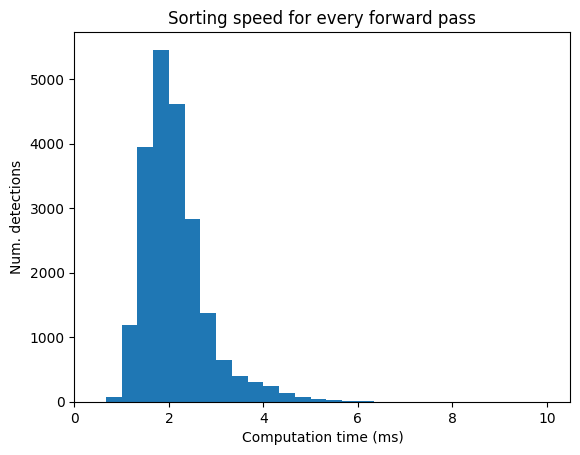

Mean: 2.12 ms
Outliers: [65.98610798]


IndexError: arrays used as indices must be of integer (or boolean) type

In [13]:
delays_total = np.array(delays_total)
delays_total_spike_detected = np.array(delays_total_spike_detected)

delays = delays_total
plt.hist(delays, bins=30, range=(0, 10))
plt.title("Sorting speed for every forward pass")
plt.xlabel("Computation time (ms)")
plt.ylabel("Num. detections")
plt.xlim(0)
plt.show()
print(f"Mean: {np.mean(delays):.2f} ms")
print(f"Outliers: {delays[delays > 10]}")

delays = delays_total[delays_total_spike_detected]
plt.hist(delays, bins=30, range=(0, 10))
plt.title("Sorting speed for detections")
plt.xlabel("Computation time (ms)")
plt.ylabel("Num. detections")
plt.xlim(0)
plt.show()
print(f"Mean: {np.mean(delays):.2f} ms")
print(f"Outliers: {delays[delays > 10]}")

delays = delays_total[~delays_total_spike_detected]
plt.hist(delays, bins=30, range=(0, 10))
plt.title("Sorting speed for no detections")
plt.xlabel("Computation time (ms)")
plt.ylabel("Num. detections")
plt.xlim(0)
plt.show()
print(f"Mean: {np.mean(delays):.2f} ms")
print(f"Outliers: {delays[delays > 10]}")

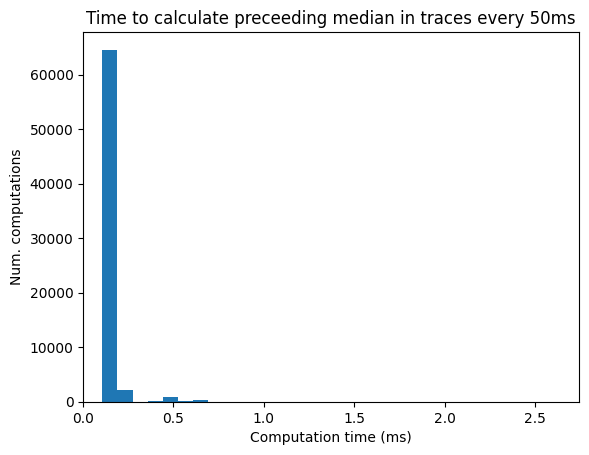

Mean: 0.13 ms


In [110]:
plt.hist(delays_pre_median, bins=30)
plt.title("Time to calculate preceeding median in traces every 50ms")
plt.xlim(0)
plt.ylabel("Num. computations")
plt.xlabel("Computation time (ms)")
plt.show()
print(f"Mean: {np.mean(delays_pre_median):.2f} ms")

## Tuning

In [21]:
import comet_ml

%autoreload 2
from src.analysis.rt_sort.comparison import DummySorter, Comparison

COMET INFO: 714ad3adc35e4e4fbea30887b1779b2f
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '714ad3adc35e4e4fbea30887b1779b2f', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '714ad3adc35e4e4fbea30887b1779b2f', 'parameters': {'MAX_AMP_MEDIAN_DIFF_SPIKES': {'max': 0.5, 'min': 0.1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_LATENCY_DIFF_SPIKES': {'max': 5, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_ROOT_AMP_MEDIAN_STD': {'max': 3, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MIN_INNER_LOOSE_DETECTIONS': {'max': 4, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'}, 'MIN_LOOSE_DETECTIONS_N': {'max': 5, 'min': 2, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'}, 'MIN_LOOSE_DETECTIONS_R': {'max': 1, 'min': 0.33, 'scalingType': 'uniform', 'scaling_type': 'uniform

0
Setting variables


100%|██████████| 68074/68074 [02:59<00:00, 380.04it/s]


64.60585143357527


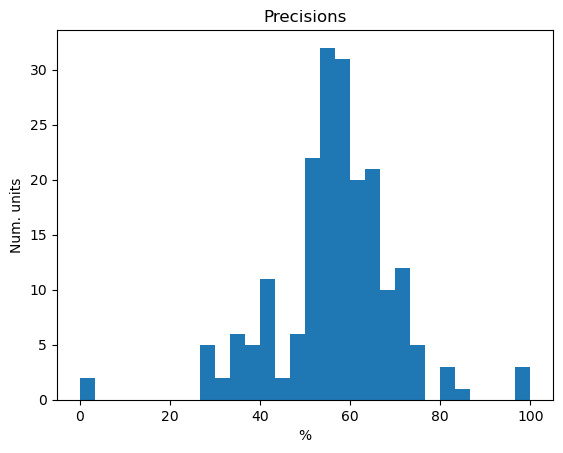

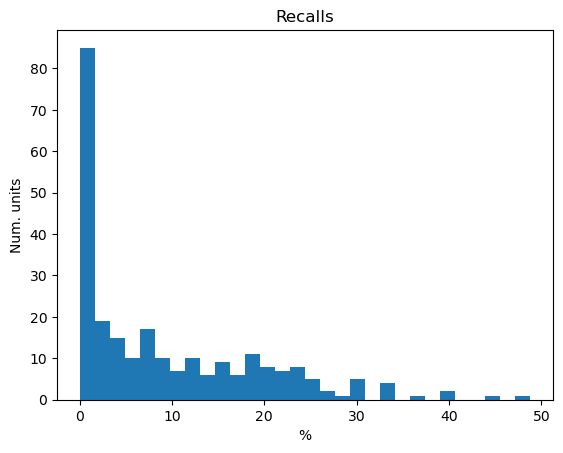

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/be4b4e1344ee4aa29d83fad8df073020



1
Setting variables


100%|██████████| 68074/68074 [03:25<00:00, 331.32it/s]


75.85793471779832


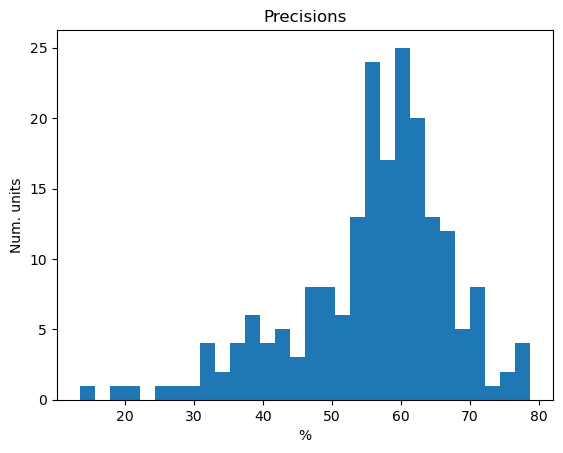

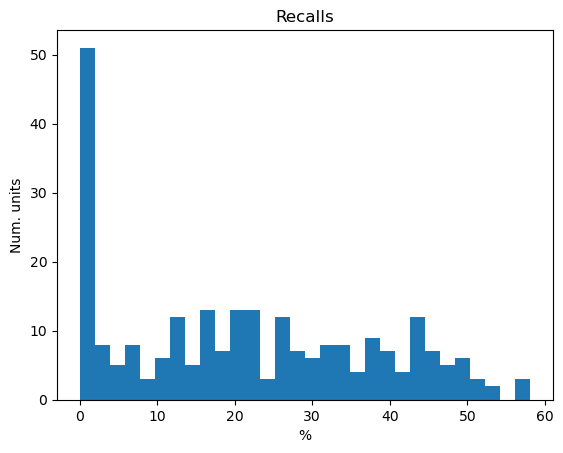

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/3a3ece2662274f3b9317ef91f74323be



2
Setting variables


100%|██████████| 68074/68074 [03:43<00:00, 305.13it/s]


92.86129270521944


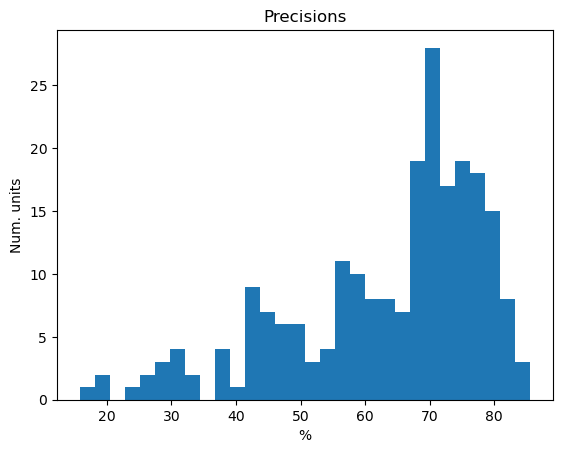

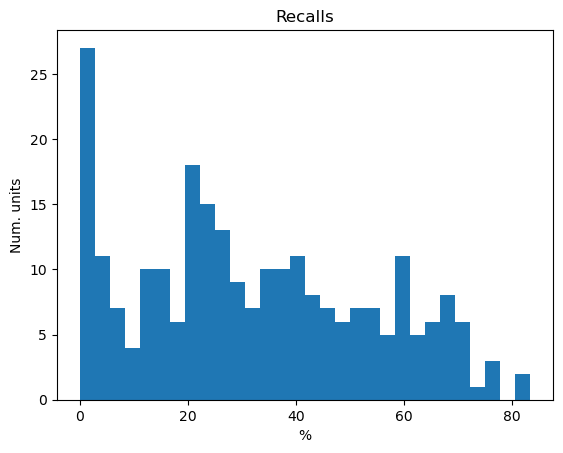

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 2 file(s), remaining 6.82 MB/6.95 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/4c13bd1565684b4fa35a3c0410525ad3



3
Setting variables


100%|██████████| 68074/68074 [03:10<00:00, 356.60it/s]


70.86249566573099


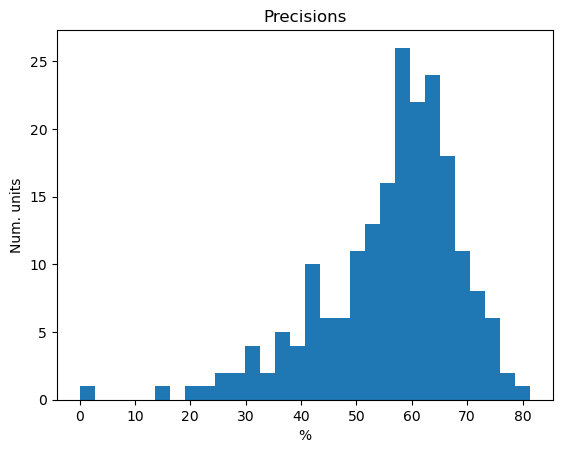

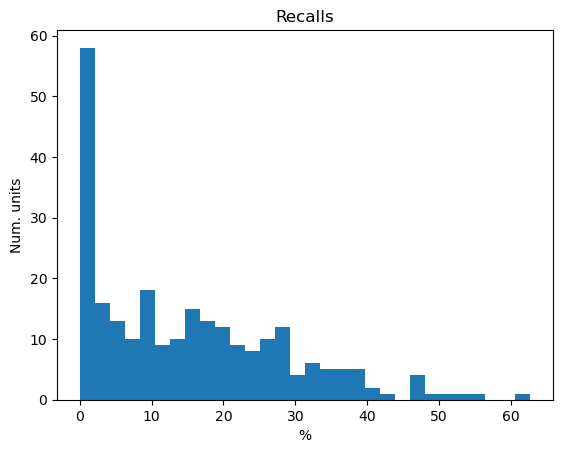

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/e3dbcd4be4bb46598d417d9e7b2830f7



4
Setting variables


100%|██████████| 68074/68074 [04:37<00:00, 245.65it/s]


112.190248935093


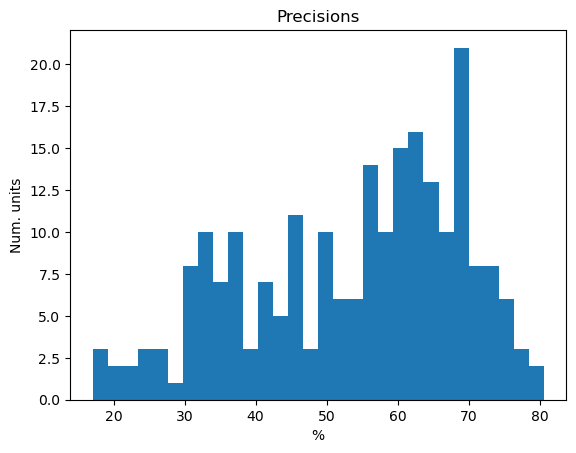

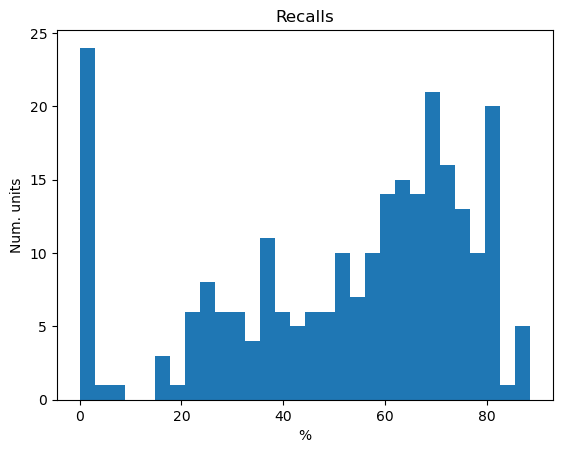

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/eaa7ea0341024a2f872419f5966cdf3e



5
Setting variables


100%|██████████| 68074/68074 [03:02<00:00, 373.78it/s]


59.67845873808065


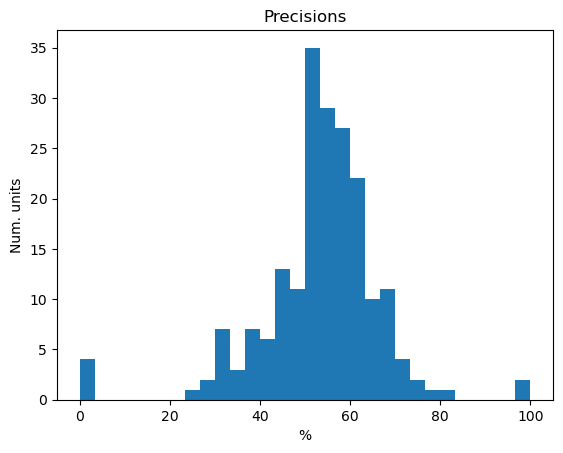

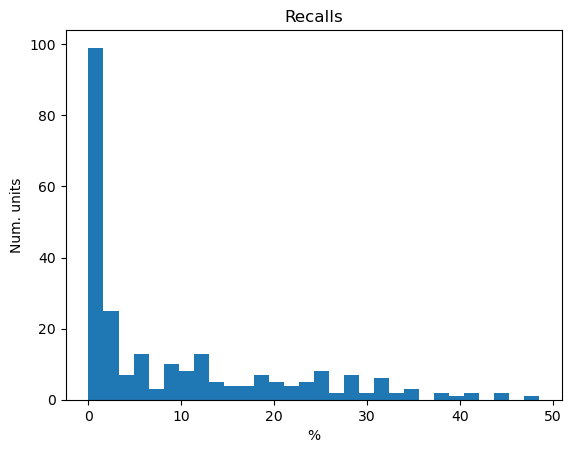

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/75402c12165b4b81816d1ff5126c160e



6
Setting variables


100%|██████████| 68074/68074 [03:01<00:00, 376.04it/s]


64.21449018153373


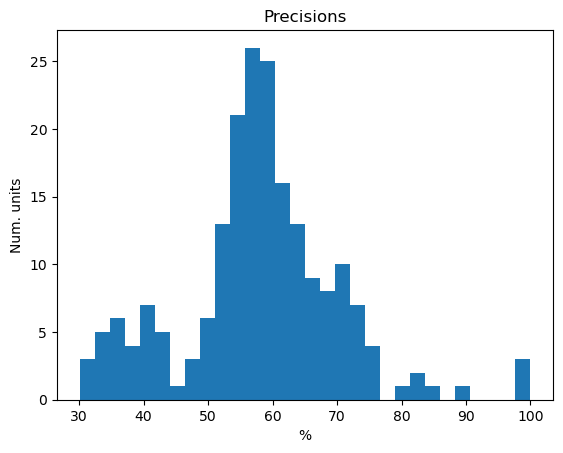

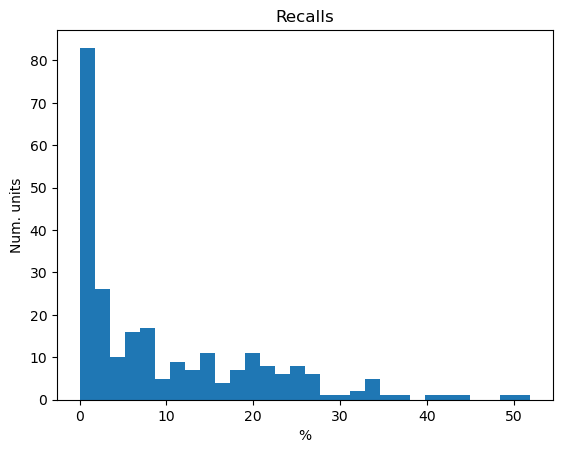

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 2 file(s), remaining 6.82 MB/6.95 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/9811df919feb4b20909f602b4e340a30



7
Setting variables


100%|██████████| 68074/68074 [02:54<00:00, 391.16it/s]


86.56015577053131


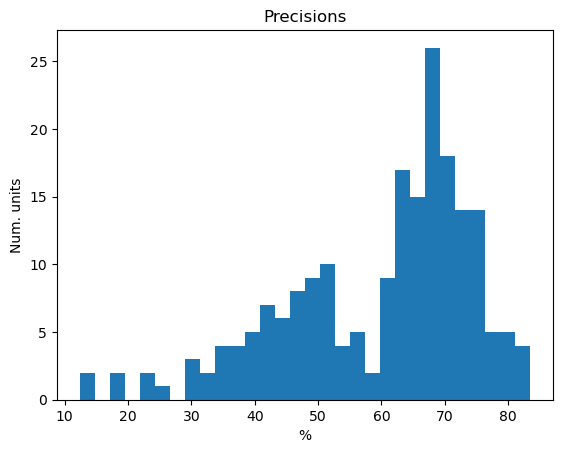

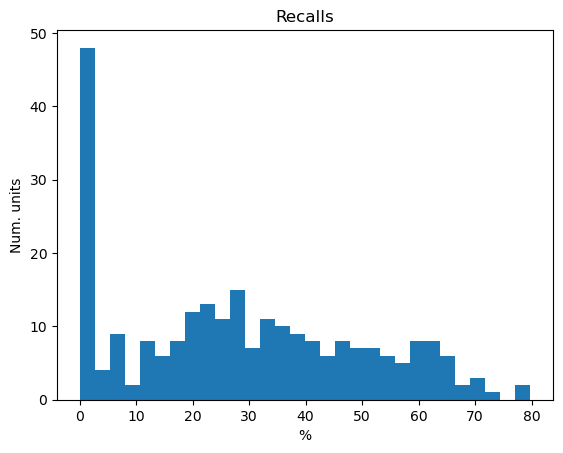

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/1e5a3ad92b754f62ac5b34404b4232b2



8
Setting variables


100%|██████████| 68074/68074 [03:40<00:00, 308.04it/s]


96.0602247395848


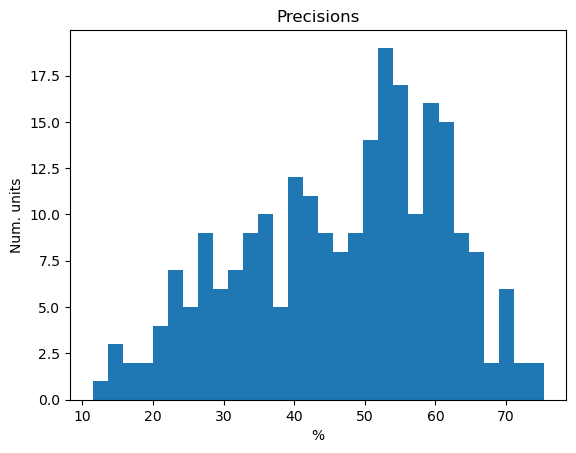

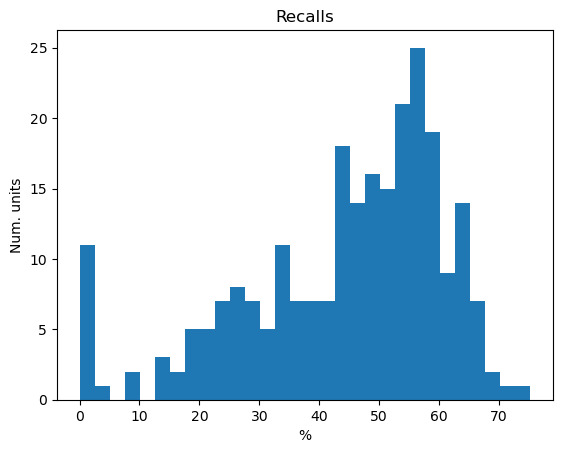

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 7 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 836.67 KB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/ba5fb4490aab42e5b19cf6727e6b2142



9
Setting variables


100%|██████████| 68074/68074 [02:54<00:00, 389.77it/s]


84.6772169719573


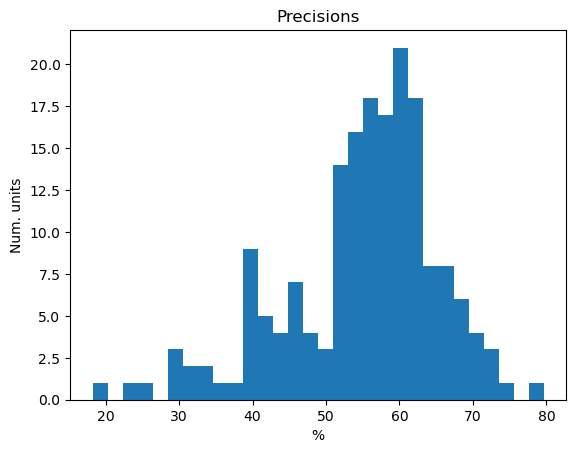

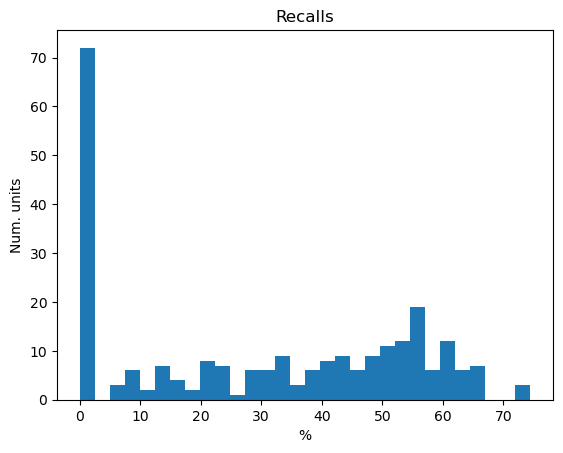

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/6f85733fcd0b4e0f9a646e93138a7a8a



10
Setting variables


100%|██████████| 68074/68074 [02:41<00:00, 420.67it/s]


54.29950666973927


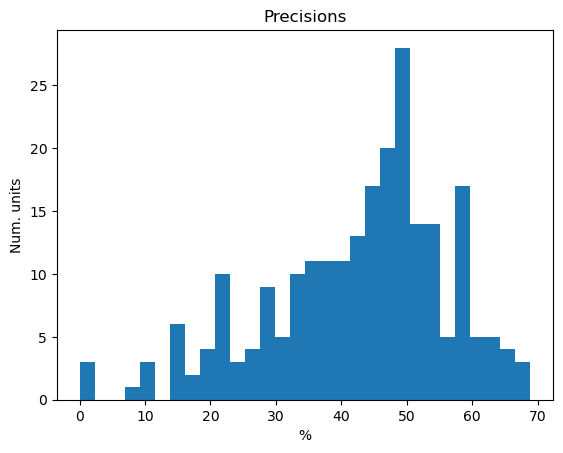

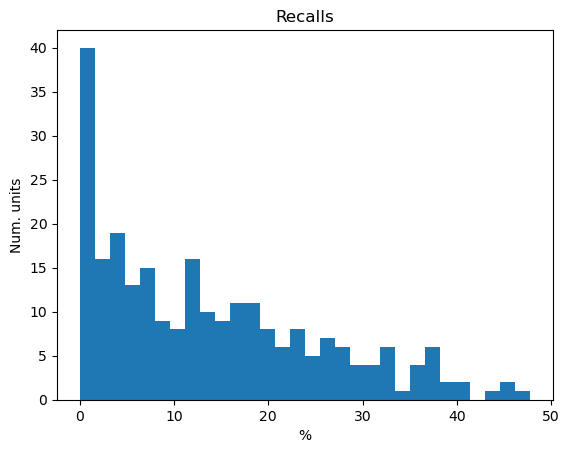

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 2 file(s), remaining 6.42 MB/6.95 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/3b47eded26ed489da1ef73971c1f2e9c



11
Setting variables


100%|██████████| 68074/68074 [02:23<00:00, 474.17it/s]


50.12802745215089


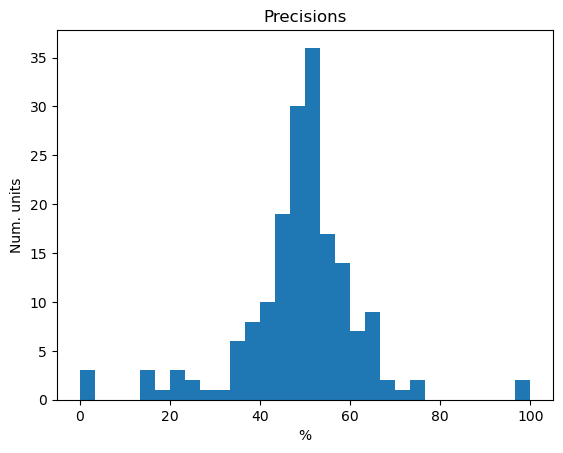

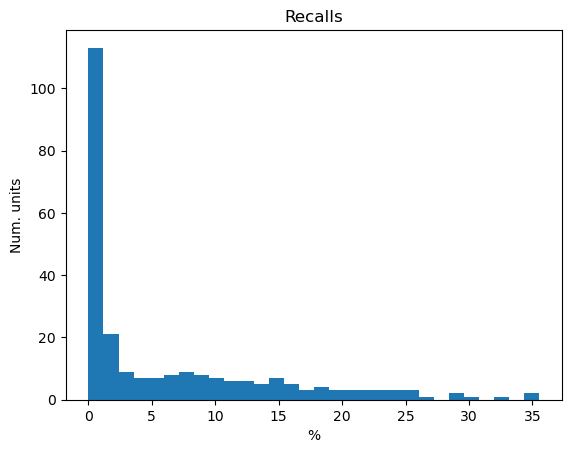

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 6 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/8ccfde9d68ba4474a45f87a12496f146



12
Setting variables


100%|██████████| 68074/68074 [03:08<00:00, 361.39it/s]


80.6154427784724


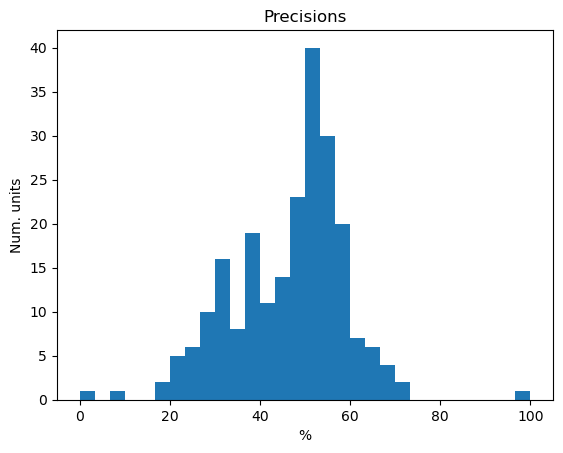

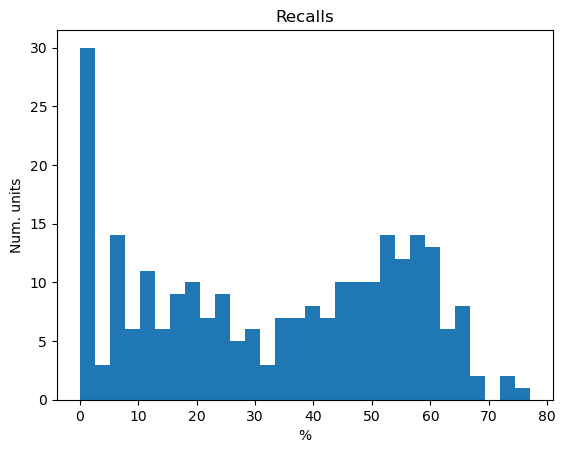

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 11 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 2 file(s), remaining 6.86 MB/6.95 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/abeaa7ad9e264e9baa7bc5f66007381c



13
Setting variables


100%|██████████| 68074/68074 [03:48<00:00, 297.87it/s]


115.44217294729665


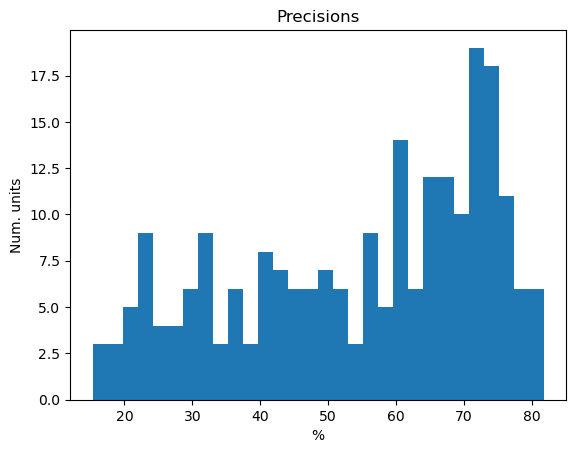

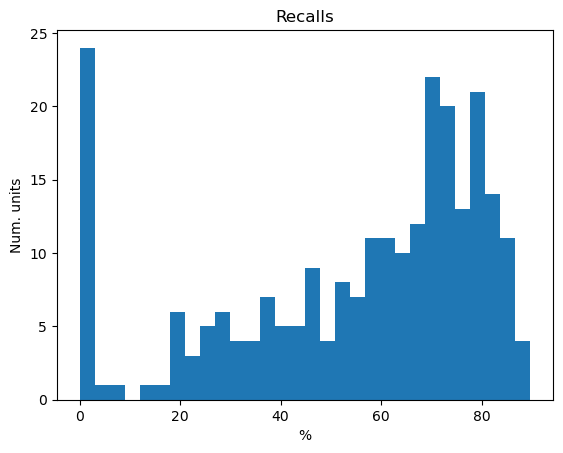

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 4.98 MB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/d1f1834dd364461db9bb404920e4309c



14
Setting variables


100%|██████████| 68074/68074 [03:00<00:00, 377.13it/s]


81.68367502207096


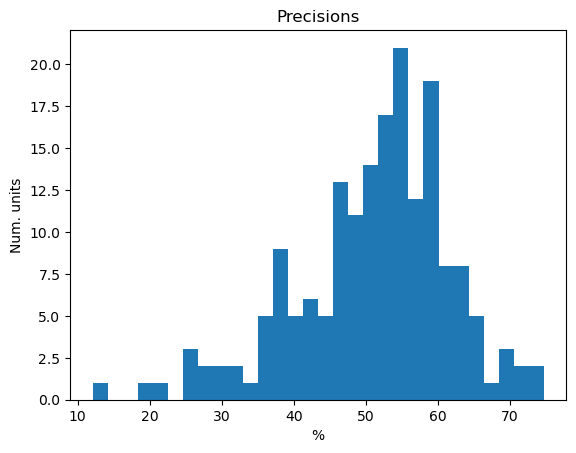

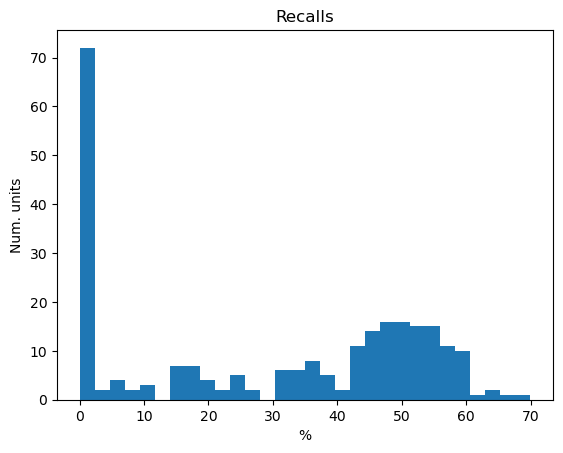

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/59ab9777211c40d9849c85d38c930148



15
Setting variables


100%|██████████| 68074/68074 [02:16<00:00, 497.04it/s]


54.749499432773504


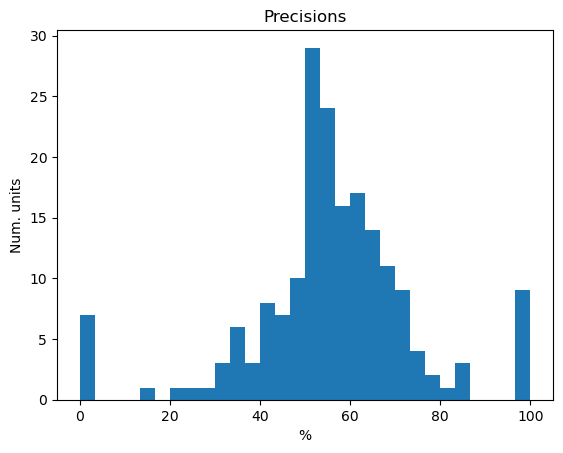

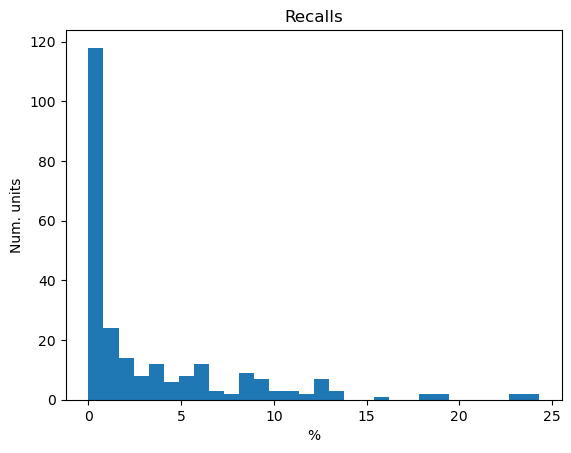

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/ec27d0850f284bcfa444a5d158acf313



16
Setting variables


100%|██████████| 68074/68074 [02:42<00:00, 417.97it/s]


75.45691263054094


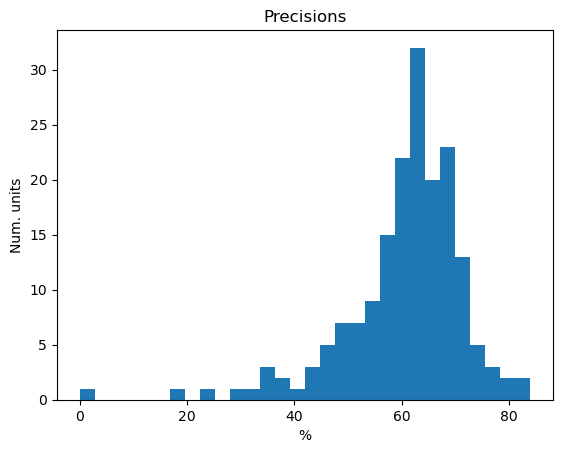

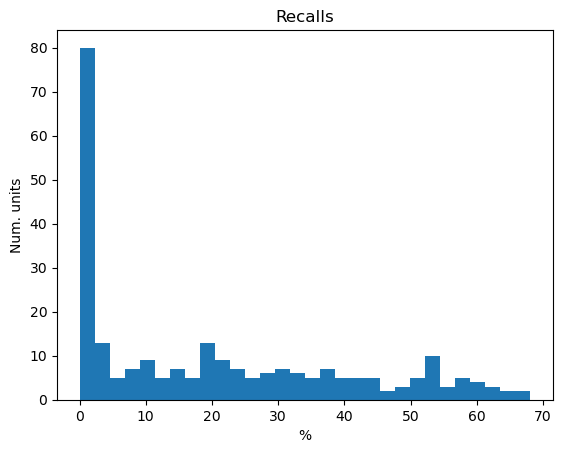

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 6 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 188.67 KB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/6bad9793d6374ef19c7f22242ae4d90f



17
Setting variables


100%|██████████| 68074/68074 [03:01<00:00, 375.60it/s]


82.35139654358267


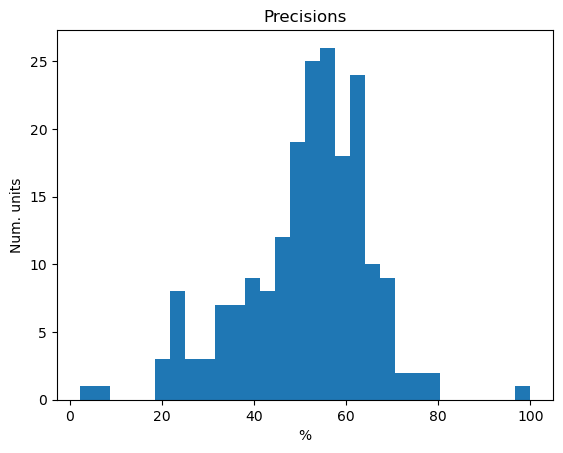

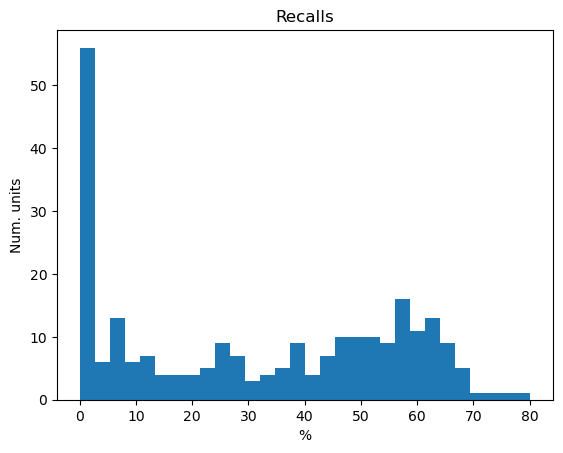

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 2 file(s), remaining 6.75 MB/6.95 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/d7e40cc55e1f481a873df61d61053e8e



18
Setting variables


100%|██████████| 68074/68074 [03:14<00:00, 350.51it/s]


86.4949015568002


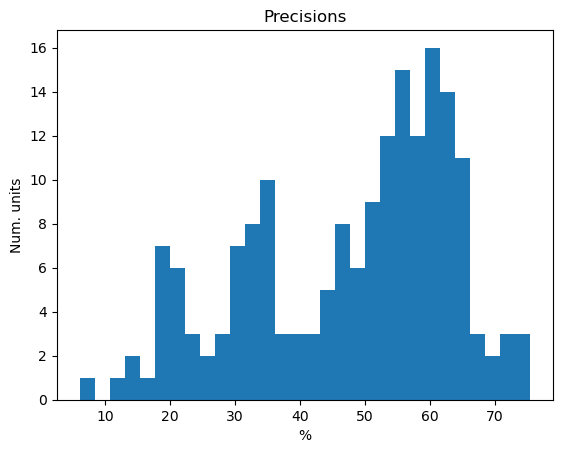

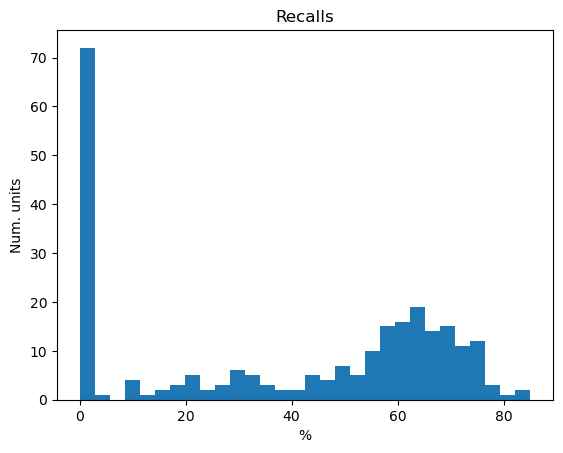

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 8 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 2.58 MB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/4cfaa0aa43d5474bb8f811d587bd5b60



19
Setting variables


100%|██████████| 68074/68074 [02:43<00:00, 415.54it/s]


68.43941559022838


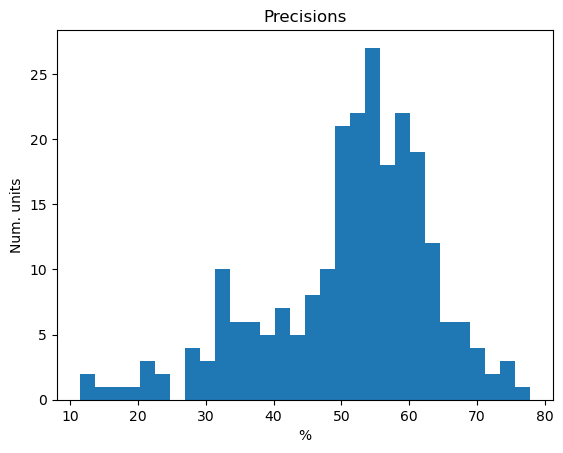

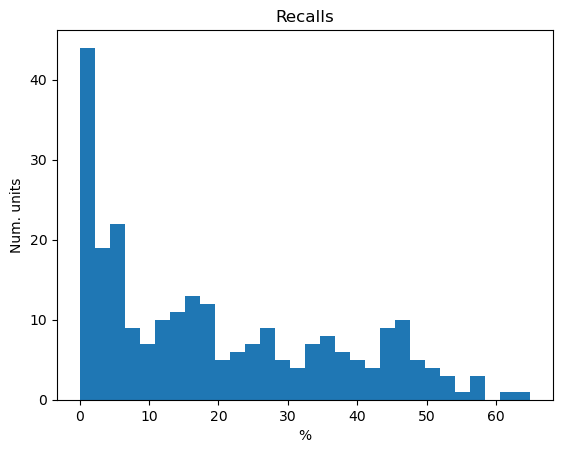

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 4.79 MB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/c92a23e5e1ad48c3b4bd4ace162d104f



20
Setting variables


100%|██████████| 68074/68074 [03:52<00:00, 293.13it/s]


103.12502492874981


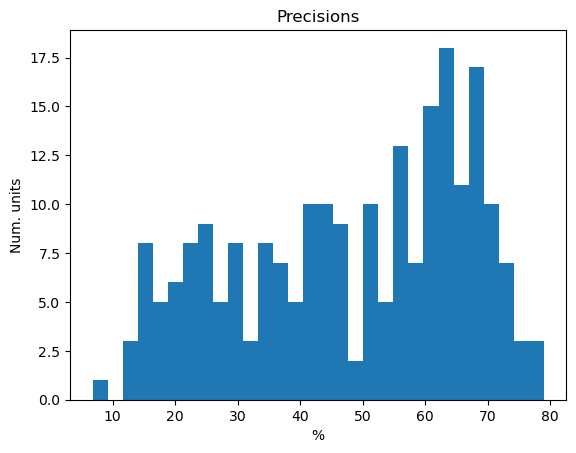

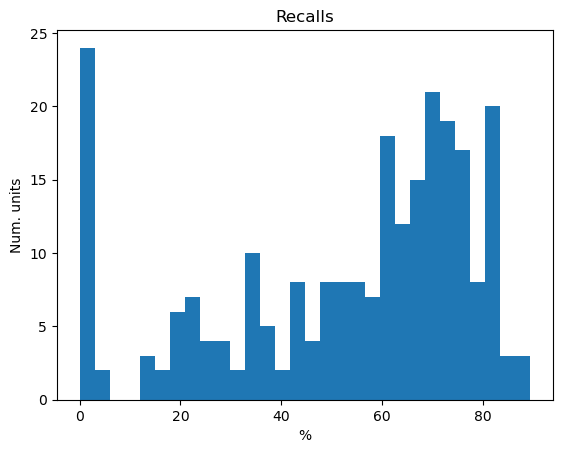

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 6 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 1.39 MB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/ec18d67c3cc44694b95994e3b2d3cf92



21
Setting variables


100%|██████████| 68074/68074 [03:35<00:00, 315.48it/s]


113.11242520543286


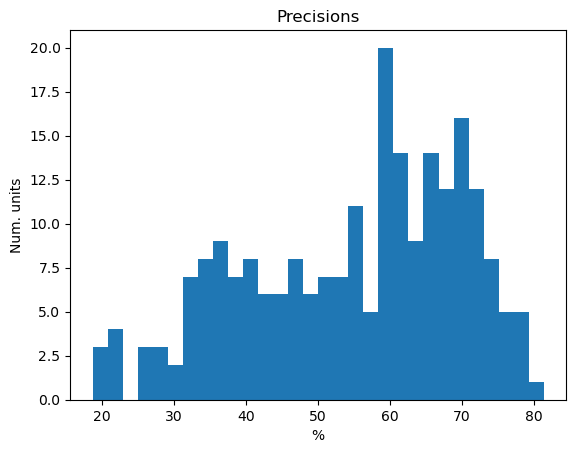

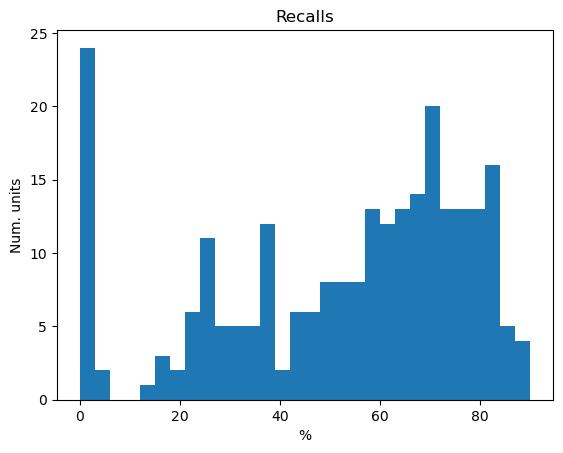

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 7 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 948.67 KB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/6e97be62c9f74915b9a8b1340ce8bbaf



22
Setting variables


100%|██████████| 68074/68074 [03:11<00:00, 355.80it/s]


99.94415783226319


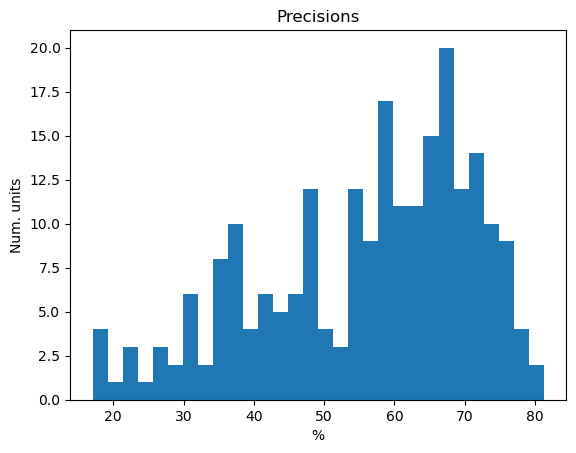

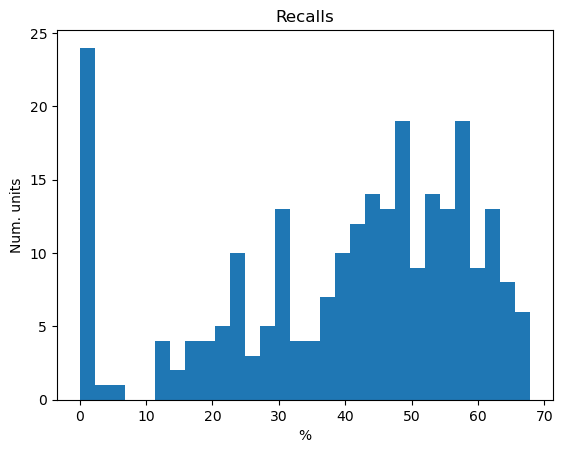

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/f18b3f8818984946b4fc06ac4cff365f



23
Setting variables


100%|██████████| 68074/68074 [03:42<00:00, 306.07it/s]


115.22750059357281


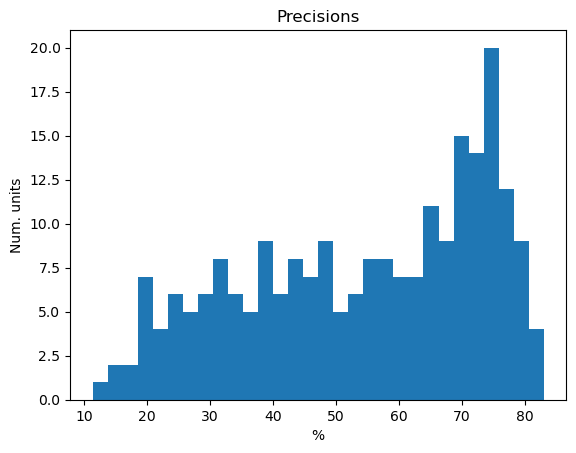

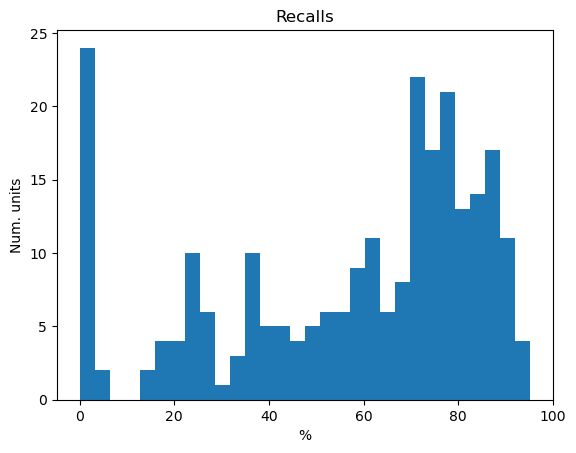

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/3c9db3d1a6dc402889039fc72699f154



24
Setting variables


100%|██████████| 68074/68074 [03:43<00:00, 304.34it/s]


112.17084483377548


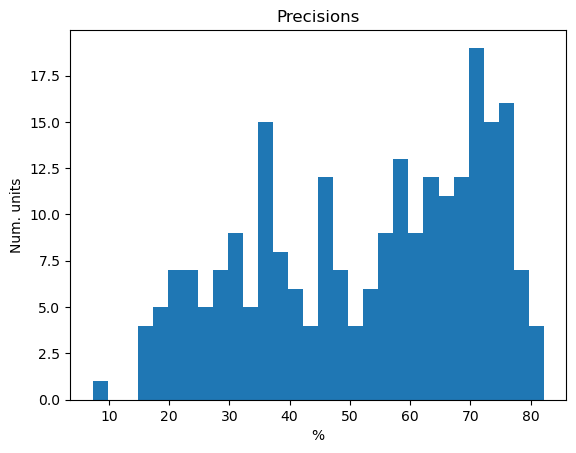

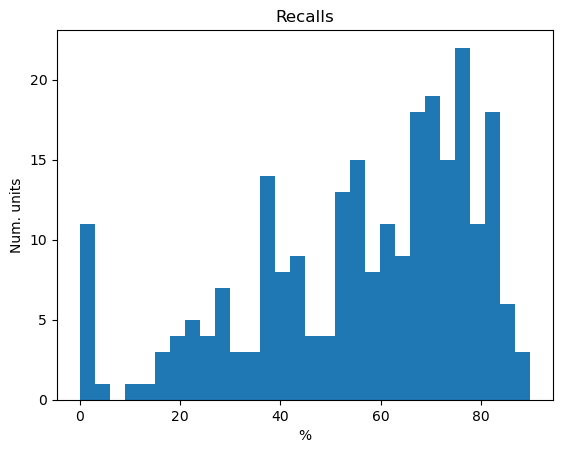

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 6 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/d1c1de14c95548c6a1ed57a1484bc73f



25
Setting variables


100%|██████████| 68074/68074 [03:46<00:00, 301.11it/s]


113.4075439917153


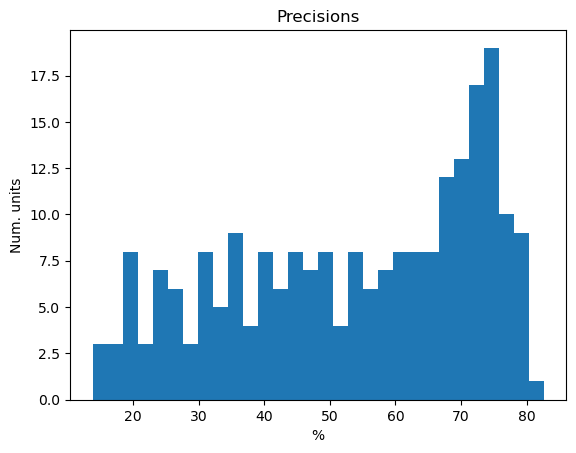

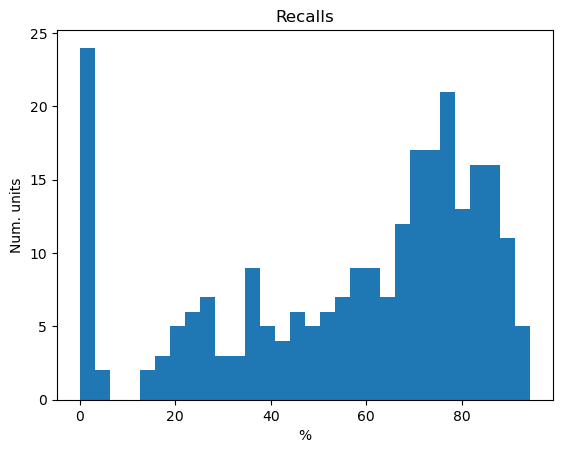

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/5f020f35e05b4286858328a1eaaf3838



26
Setting variables


100%|██████████| 68074/68074 [03:50<00:00, 295.42it/s]


113.19839494082991


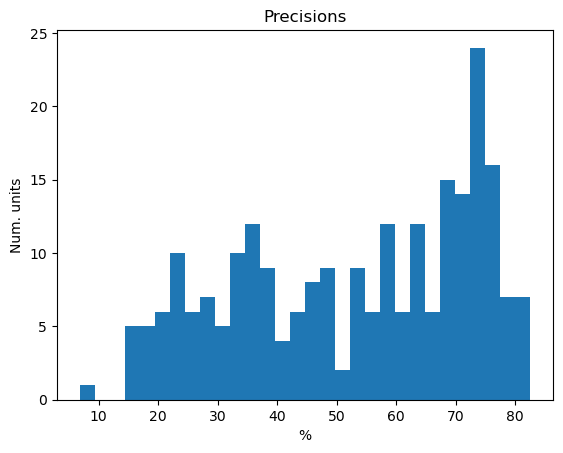

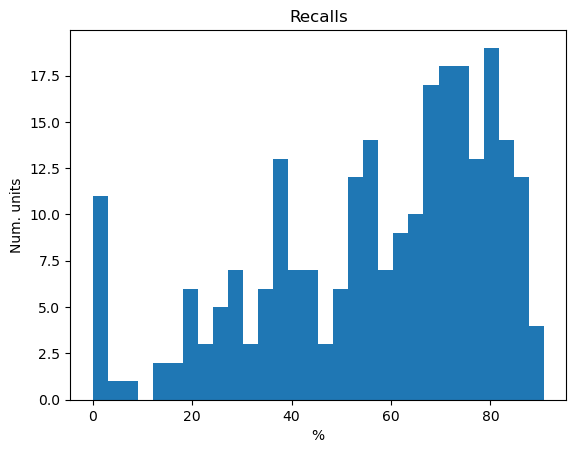

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 7 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/754646f93ad24447b25d3606ed956a93



27
Setting variables


100%|██████████| 68074/68074 [03:35<00:00, 315.46it/s]


115.21673850727194


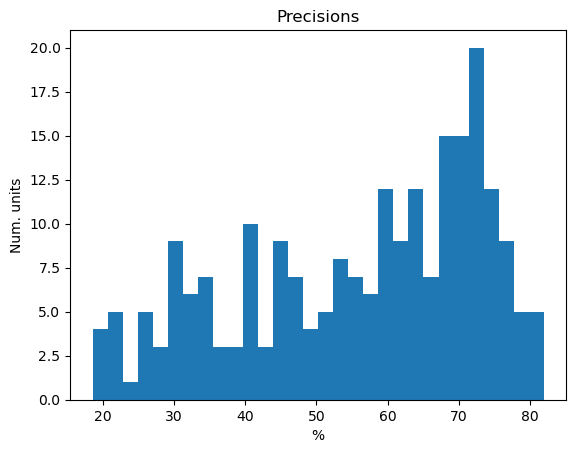

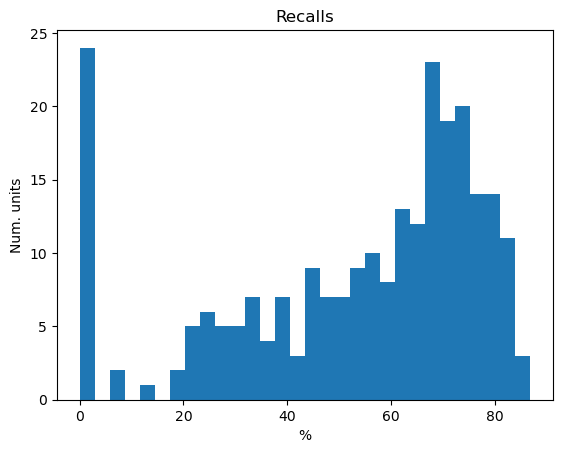

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 7 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 852.67 KB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/7004494750174b3e972306ba95f940c1



28
Setting variables


100%|██████████| 68074/68074 [03:32<00:00, 319.91it/s]


119.15393897518535


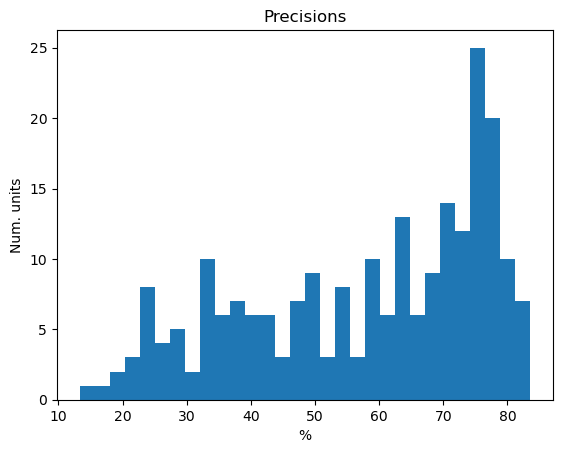

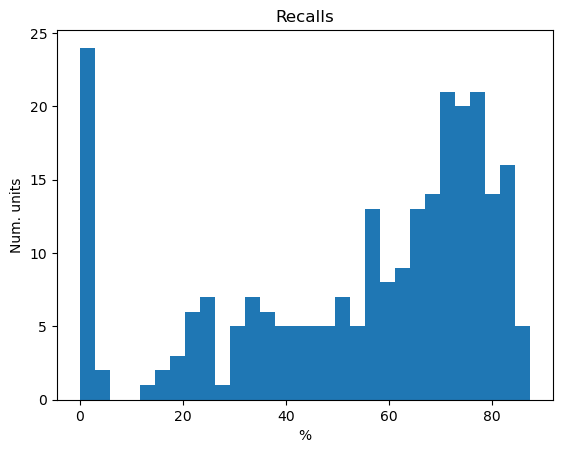

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/087c7d2c12ca47d88e0f6375981dc275



29
Setting variables


100%|██████████| 68074/68074 [03:25<00:00, 331.93it/s]


101.6450945004186


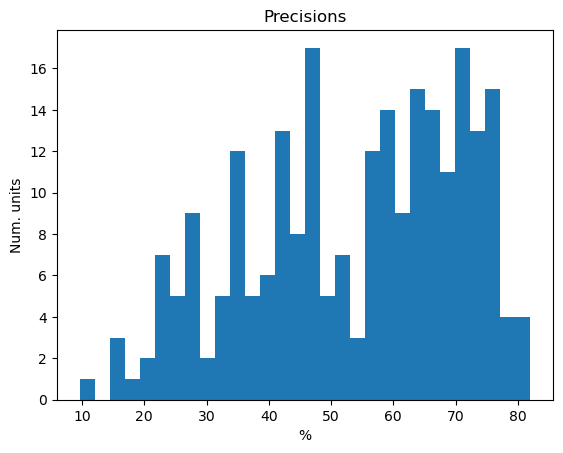

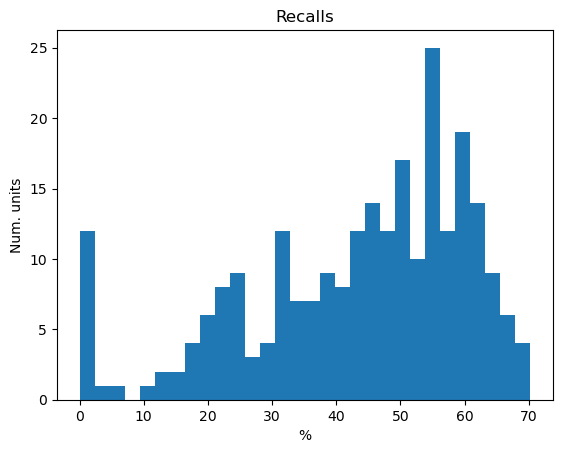

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 7 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 1.85 MB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/8373541d658d4bf392d3dc11575f0eb2



30
Setting variables


100%|██████████| 68074/68074 [03:16<00:00, 345.74it/s]


94.42146825854378


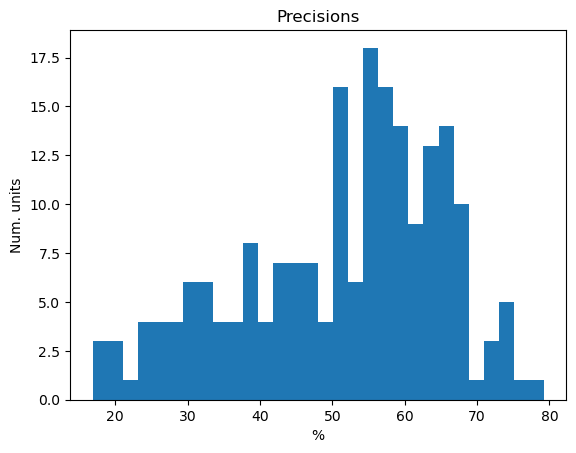

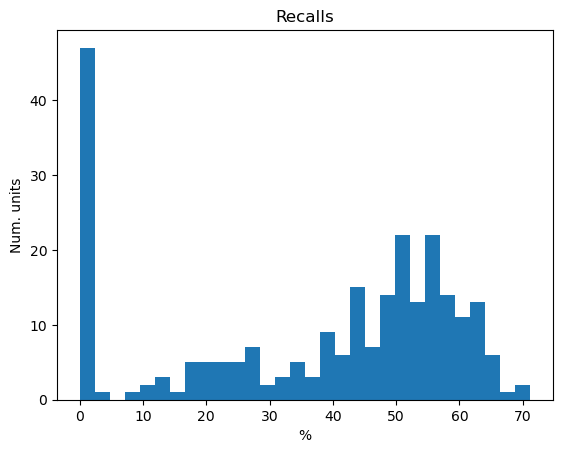

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/9c5714e00b574753bff68b513c06d0dd



31
Setting variables


100%|██████████| 68074/68074 [03:37<00:00, 312.77it/s]


116.92592855916325


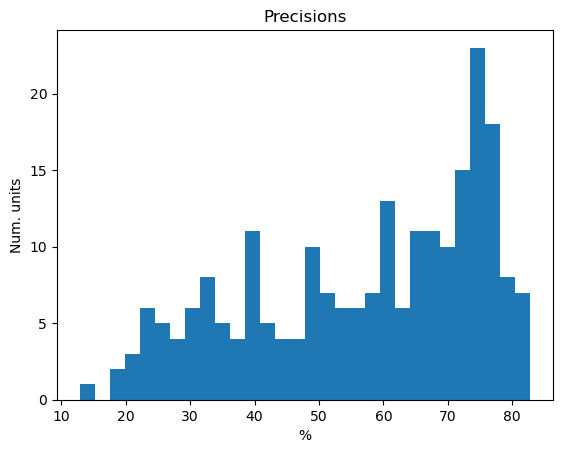

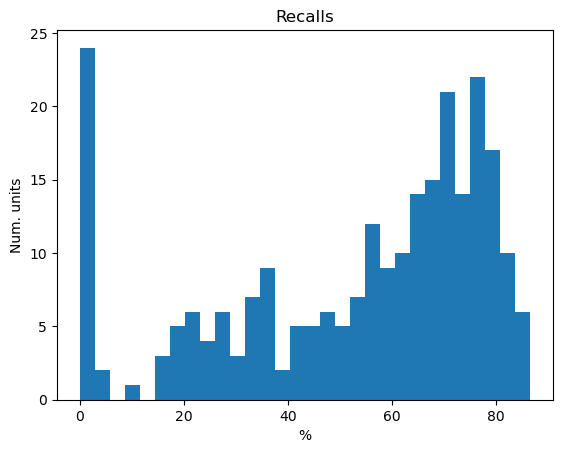

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 7 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 860.67 KB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/f862f5444ac2449f805cfc360123191c



32
Setting variables


100%|██████████| 68074/68074 [03:36<00:00, 314.25it/s]


114.51496802859094


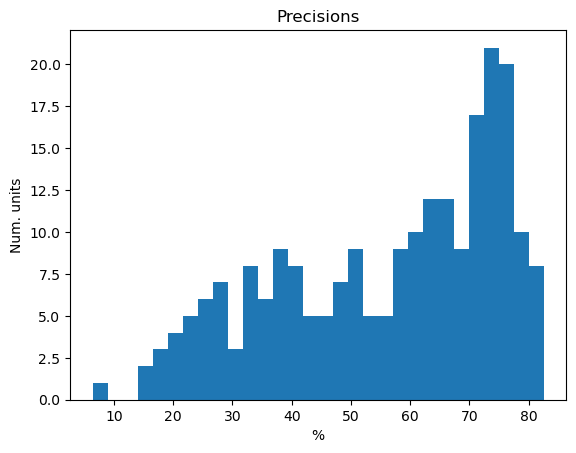

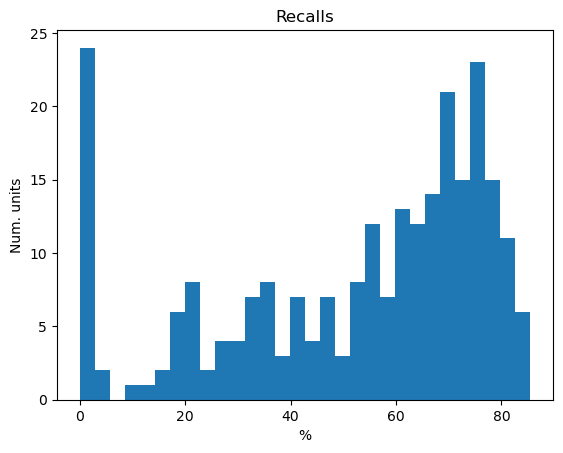

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 748.67 KB/6.91 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/02efa5d5c0d745678bb030f4c225b751



33
Setting variables


 40%|███▉      | 26894/68074 [01:12<01:50, 372.01it/s]


KeyboardInterrupt: 

In [46]:
EXPERIMENT_CONFIG = {
        "api_key": "max_api_key",
        "project_name": "si_sim_assign_spikes",
        "workspace": "max-workspace",

        "display_summary_level": 0,
    }

EXP_NAME_BASE = "SpikeTuning0.1_"

OPTIMIZER_CONFIG = {
        "algorithm": "bayes",
        "spec": {
            "maxCombo": 0,
            "metric": "performance",
            "objective": "maximize",},

        "parameters": {
            "MIN_LOOSE_DETECTIONS_N": {"type": "integer", "scaling_type": "uniform", "min": 2, "max": 5},
            "MIN_LOOSE_DETECTIONS_R": {"type": "float", "scaling_type": "uniform", "min": 0.33, "max": 1},
            "MIN_INNER_LOOSE_DETECTIONS": {"type": "integer", "scaling_type": "uniform", "min": 1, "max": 4},
            # "MIN_ELEC_PROB": {"type": "float", "scaling_type": "uniform", "min": 0.01, "max": 0.1},
            "MAX_LATENCY_DIFF_SPIKES": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 5}, 
            "MAX_AMP_MEDIAN_DIFF_SPIKES": {"type": "float", "scaling_type": "uniform", "min": 0.1, "max": 0.5},  
            "MAX_ROOT_AMP_MEDIAN_STD": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 3},
            # "MAX_LATENCY_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 5},
            # "MAX_AMP_MEDIAN_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 0.1, "max": 0.5}
        }
    }

opt = comet_ml.Optimizer(config=OPTIMIZER_CONFIG)      
for i_exp, exp in enumerate(opt.get_experiments(**EXPERIMENT_CONFIG)):

    print(i_exp)
    print("Setting variables")
    
    MIN_LOOSE_DETECTIONS_N = exp.get_parameter("MIN_LOOSE_DETECTIONS_N")
    MIN_LOOSE_DETECTIONS_R = exp.get_parameter("MIN_LOOSE_DETECTIONS_R")
    MIN_INNER_LOOSE_DETECTIONS = exp.get_parameter("MIN_INNER_LOOSE_DETECTIONS")
    MAX_LATENCY_DIFF_SPIKES = exp.get_parameter("MAX_LATENCY_DIFF_SPIKES")
    MAX_AMP_MEDIAN_DIFF_SPIKES = exp.get_parameter("MAX_AMP_MEDIAN_DIFF_SPIKES")
    MAX_ROOT_AMP_MEDIAN_STD = exp.get_parameter("MAX_ROOT_AMP_MEDIAN_STD")
    
    CLIP_LATENCY_DIFF = MAX_AMP_MEDIAN_DIFF_SPIKES * 2
    CLIP_AMP_DIFF = MAX_AMP_MEDIAN_DIFF_SPIKES * 2
    
    seqs_min_loose_elecs = [ceil(max(MIN_LOOSE_DETECTIONS_N, MIN_LOOSE_DETECTIONS_R * len(seq.loose_elecs))) for seq in all_sequences]
    seqs_min_loose_elecs = torch.tensor(seqs_min_loose_elecs, dtype=torch.int16, device="cuda")

    seq_detections = get_seq_detections()

    detected_spike_times = []
    for detections in seq_detections:
        detected_spike_times.append(np.sort([d.item() / SAMP_FREQ for d in detections]))
        
    gt_spike_times = []
    for seq in all_sequences:
        spike_train = seq.formation_spike_train
        gt_spike_times.append(np.sort(spike_train[spike_train >= PRE_MEDIAN_FRAMES/SAMP_FREQ]))

    precisions, recalls = [], []
    performances = []
    for detected, gt in zip(detected_spike_times, gt_spike_times):
        num_matches = Comparison.count_matching_events(detected, gt)
        if len(detected) > 0:
            precision = num_matches/len(detected) * 100
            precisions.append(precision)
        else:
            precision = 0
        recall = num_matches / len(gt) *100
        recalls.append(recall)
        performances.append(recall + precision)
    performance = np.median(performances)
    exp.log_metric("performance", performance)
    exp.set_name(EXP_NAME_BASE + f"{performance:.1f}")
    print(performance)
        
    plt.title("Precisions")
    plt.hist(precisions, bins=30)
    plt.ylabel("Num. units")
    plt.xlabel("%")
    plt.show()

    plt.title("Recalls")
    plt.hist(recalls, bins=30)
    plt.ylabel("Num. units")
    plt.xlabel("%")
    plt.show()
    
    exp.end()

COMET INFO: d996b861db204725b08d562ed063e2b7
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': 'd996b861db204725b08d562ed063e2b7', 'lastUpdateTime': None, 'maxCombo': 0, 'name': 'd996b861db204725b08d562ed063e2b7', 'parameters': {'MAX_AMP_MEDIAN_DIFF_SPIKES': {'max': 0.5, 'min': 0.1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_LATENCY_DIFF_SPIKES': {'max': 5, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_ROOT_AMP_MEDIAN_STD': {'max': 3, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MIN_INNER_LOOSE_DETECTIONS': {'max': 4, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'}, 'MIN_LOOSE_DETECTIONS_N': {'max': 5, 'min': 2, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'}, 'MIN_LOOSE_DETECTIONS_R': {'max': 1, 'min': 0.33, 'scalingType': 'uniform', 'scaling_type': 'uniform

0
Setting variables


100%|██████████| 68074/68074 [02:49<00:00, 400.99it/s]


134.2334723118692


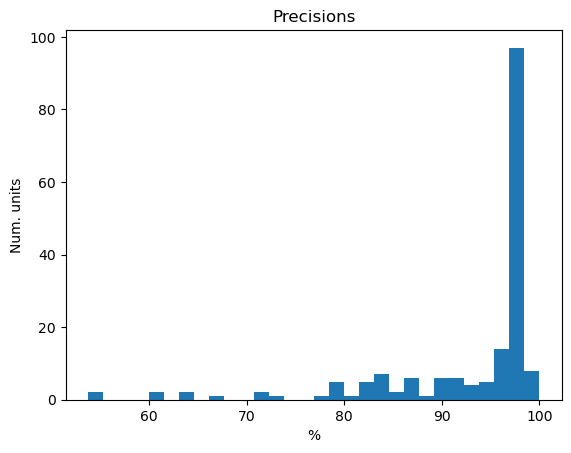

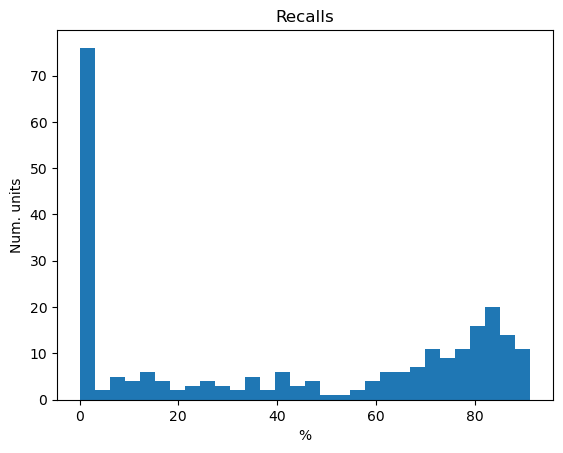

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 2.81 MB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/791a1b6d1c794db696f862e86486de7a



1
Setting variables


100%|██████████| 68074/68074 [03:23<00:00, 335.13it/s]


141.5965436962839


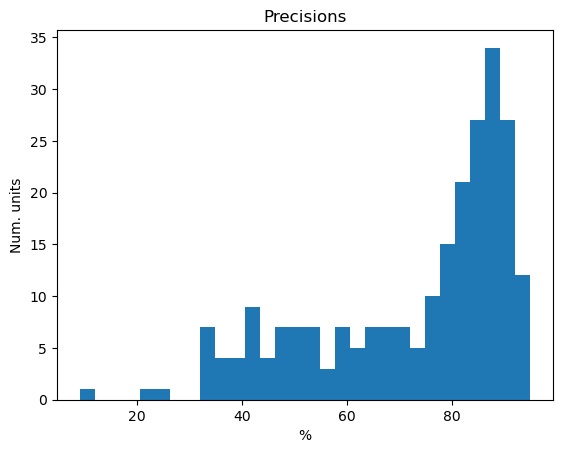

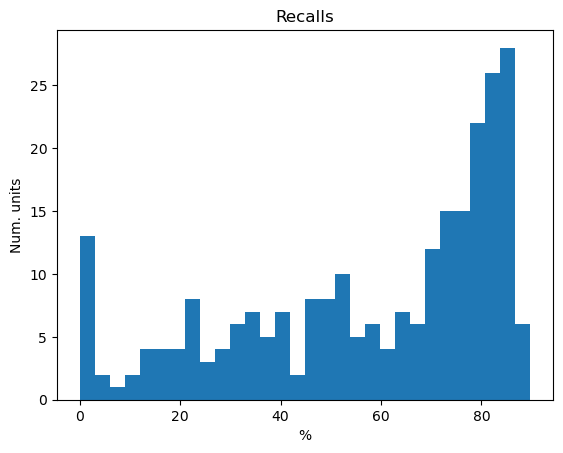

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 729.04 KB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/fff63d7042094d699f5331beff447313



2
Setting variables


100%|██████████| 68074/68074 [03:13<00:00, 351.06it/s]


150.06653928442512


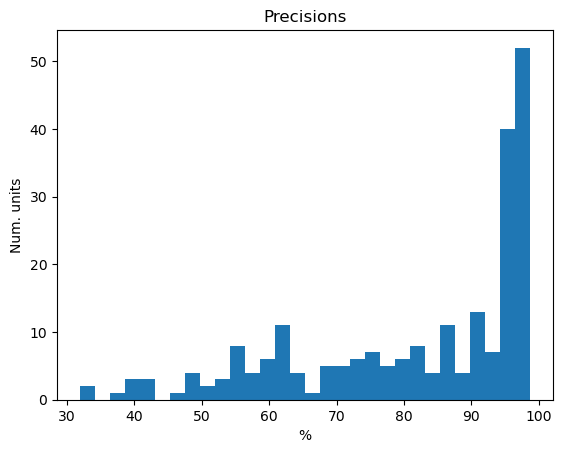

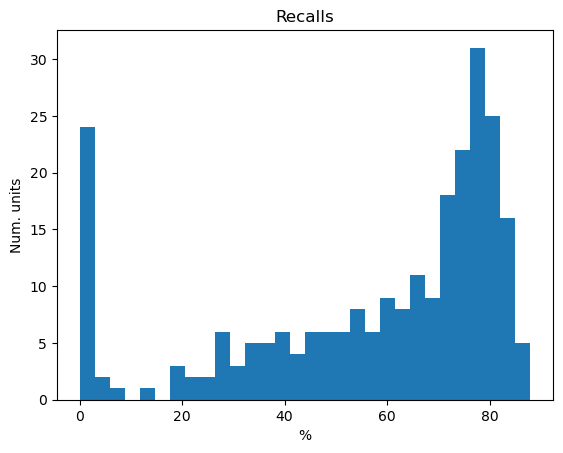

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/1280d810513b4dcd8a9a946e52cdce6c



3
Setting variables


100%|██████████| 68074/68074 [02:37<00:00, 431.53it/s]


113.15206963818497


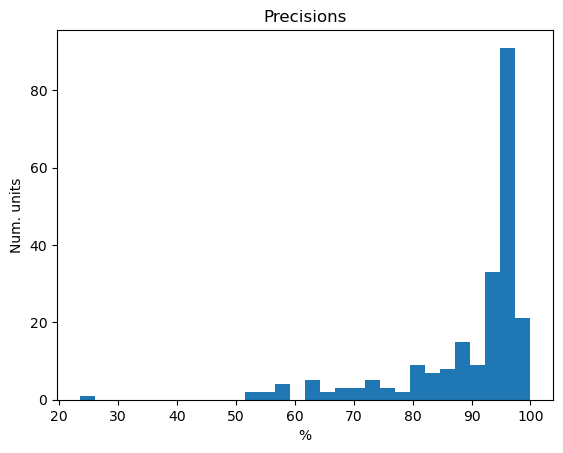

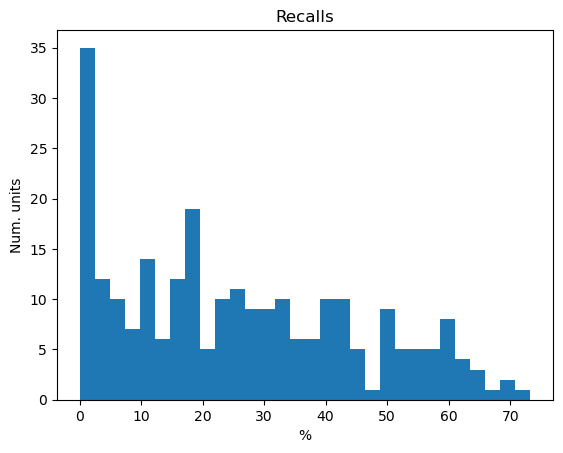

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/e9665f81702143fbb0fcf9d6767eb342



4
Setting variables


100%|██████████| 68074/68074 [02:29<00:00, 456.21it/s]


106.1484854367821


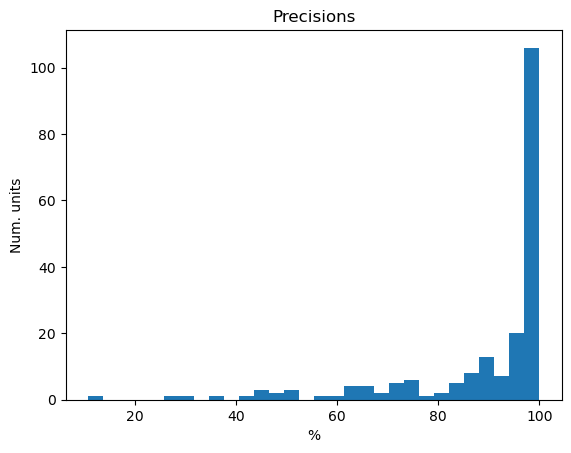

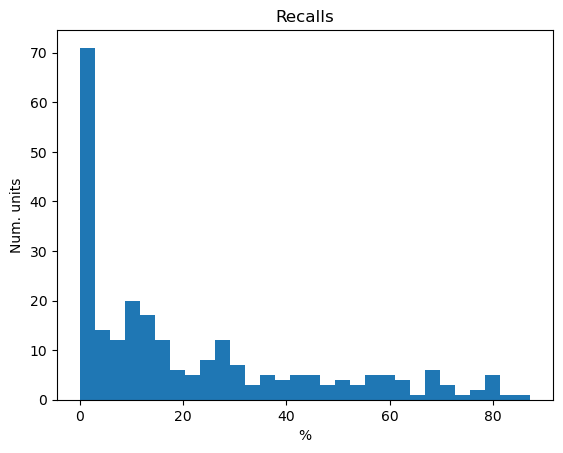

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/495ce760c0e943be81a864f9e9ad968a



5
Setting variables


100%|██████████| 68074/68074 [02:36<00:00, 436.29it/s]


113.6356714551024


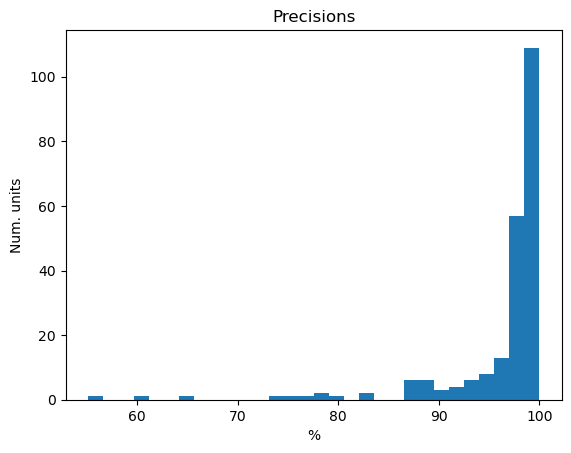

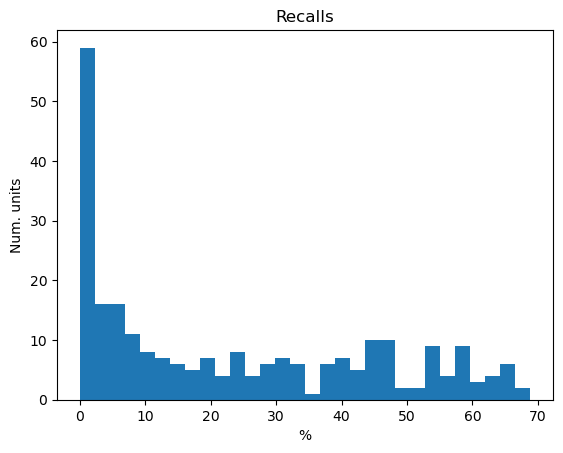

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 2.60 MB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/f31733c846af4b44b803ac7947770408



6
Setting variables


100%|██████████| 68074/68074 [03:20<00:00, 339.69it/s]


147.85778788504285


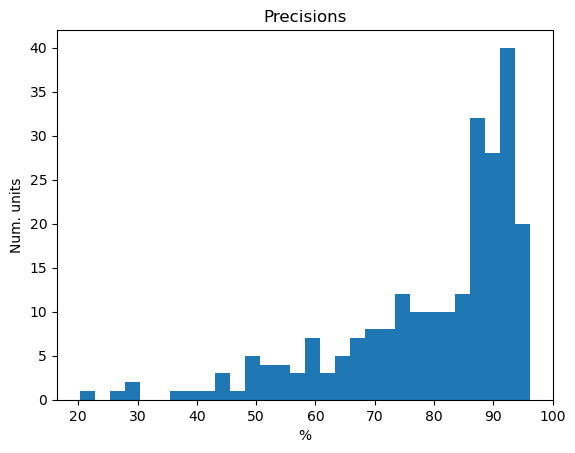

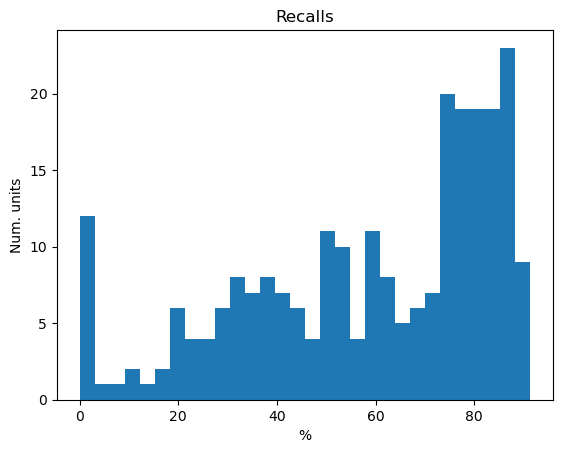

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 6 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 2.45 MB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/6106440ef8d24ba2beb31c11d695b8c9



7
Setting variables


100%|██████████| 68074/68074 [02:52<00:00, 394.55it/s]


139.99297985399085


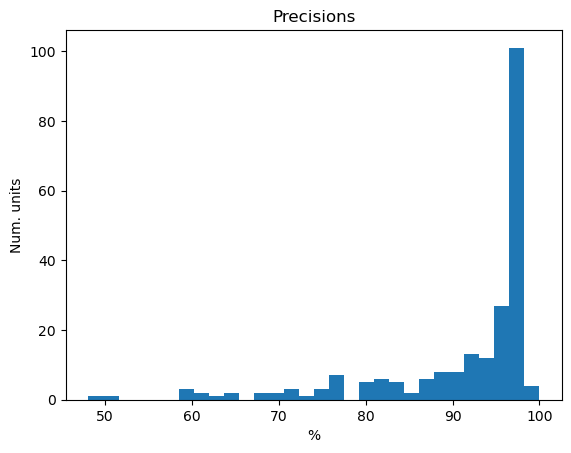

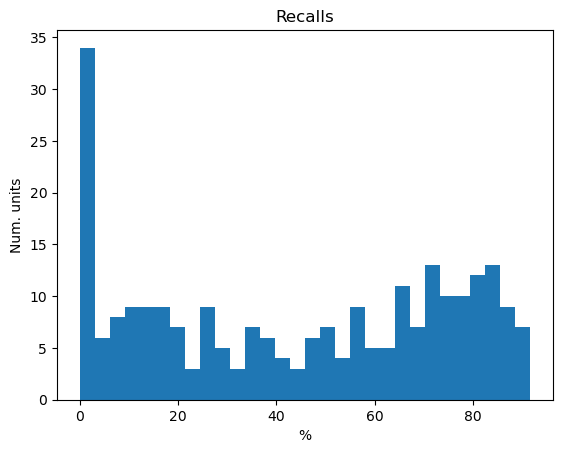

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 7 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 857.04 KB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/6a60cf65aa9043fd86fd35f7fe93ffe2



8
Setting variables


100%|██████████| 68074/68074 [02:33<00:00, 443.38it/s]


113.08724994584149


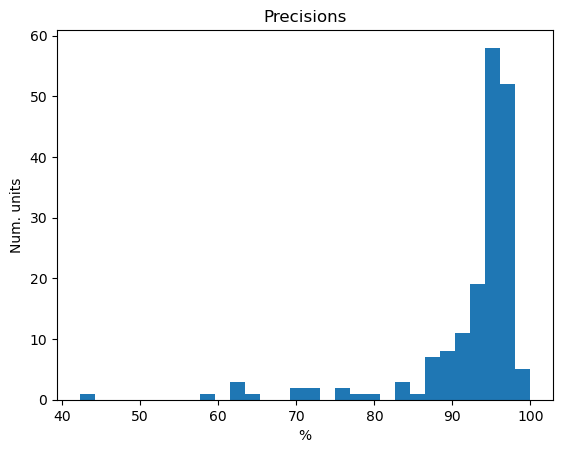

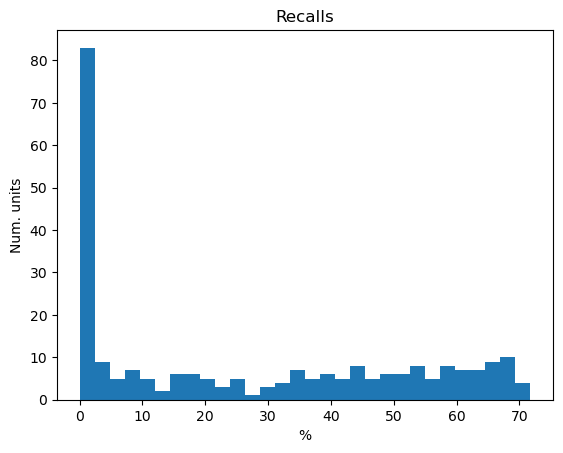

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/a8e12f2b21834dcfb33378be2aa3766b



9
Setting variables


100%|██████████| 68074/68074 [02:43<00:00, 415.95it/s]


113.39615649313862


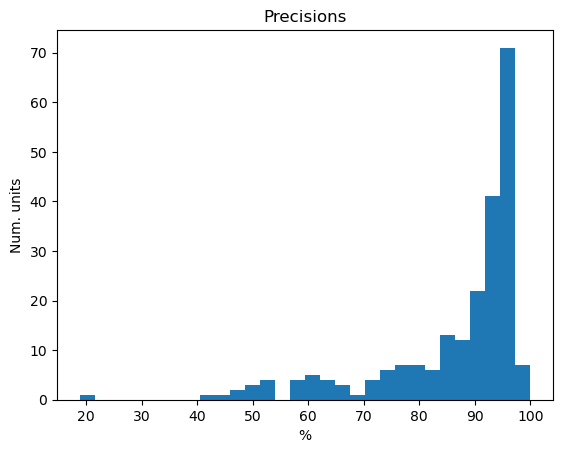

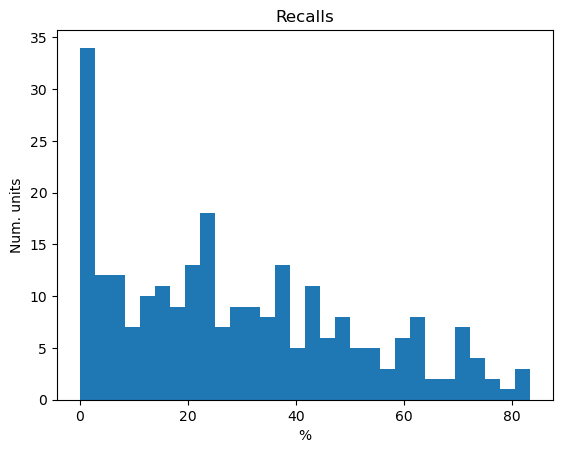

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 8 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 4.15 MB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/0bce82482f684e4f834faed247a18d93



10
Setting variables


100%|██████████| 68074/68074 [03:01<00:00, 374.99it/s]


137.77743506166246


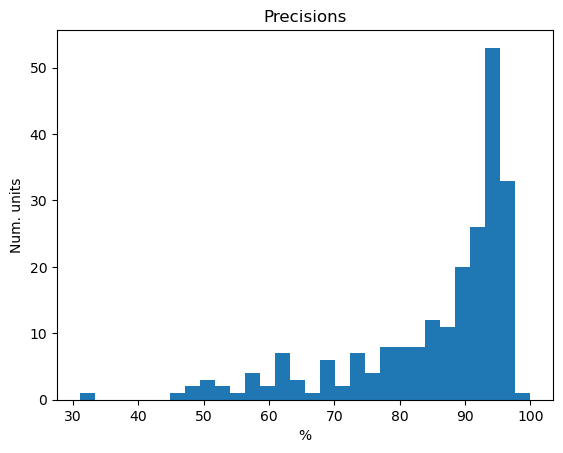

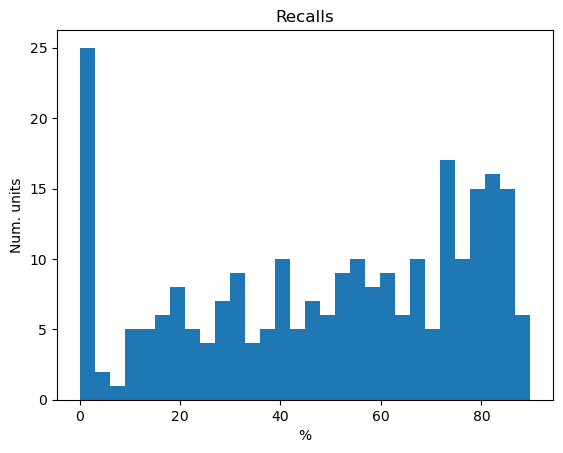

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/059a44013d0d4e98a3db45c4a0c49f3c



11
Setting variables


100%|██████████| 68074/68074 [02:30<00:00, 451.75it/s]


105.23412774935626


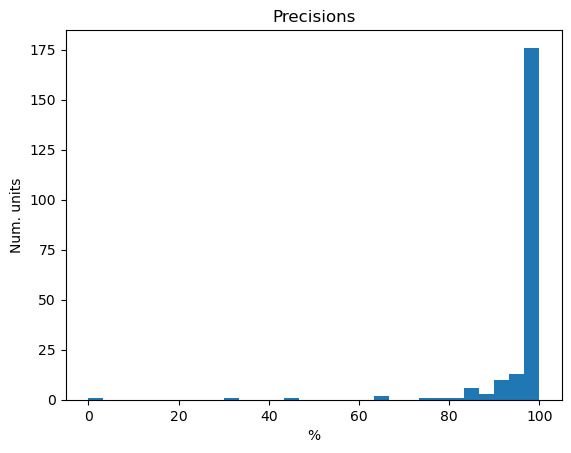

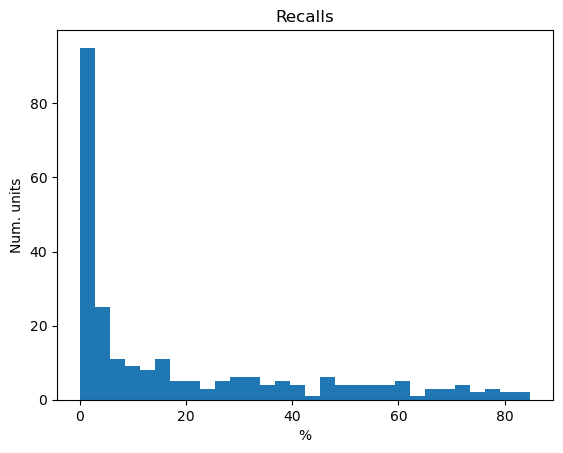

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 6 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 1.17 MB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/7183a8d6b480484fa421b1eba5833f15



12
Setting variables


100%|██████████| 68074/68074 [02:16<00:00, 499.90it/s]


100.70954840166769


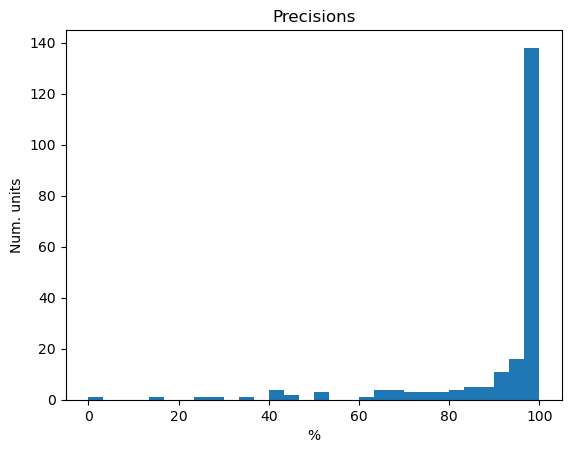

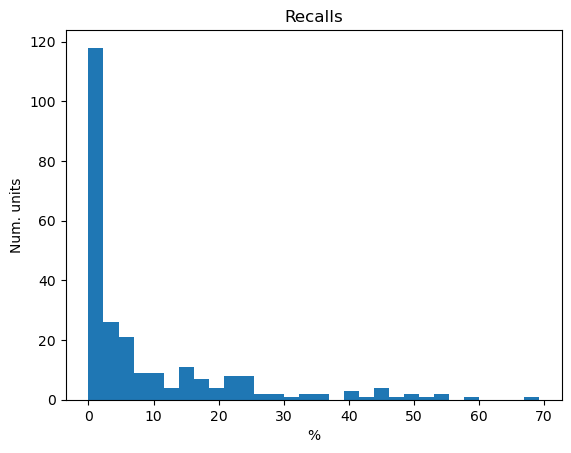

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 2 file(s), remaining 6.86 MB/6.96 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/d2d29c57f8da45fc94dc9528b3583a5a



13
Setting variables


 26%|██▋       | 17928/68074 [00:37<01:44, 477.77it/s]


KeyboardInterrupt: 

In [47]:
EXPERIMENT_CONFIG = {
        "api_key": "max_api_key",
        "project_name": "si_sim_assign_spikes",
        "workspace": "max-workspace",

        "display_summary_level": 0,
    }

EXP_NAME_BASE = "SpikeTuning0.1_"

OPTIMIZER_CONFIG = {
        "algorithm": "bayes",
        "spec": {
            "maxCombo": 0,
            "metric": "performance",
            "objective": "maximize",},

        "parameters": {
            "MIN_LOOSE_DETECTIONS_N": {"type": "integer", "scaling_type": "uniform", "min": 2, "max": 5},
            "MIN_LOOSE_DETECTIONS_R": {"type": "float", "scaling_type": "uniform", "min": 0.33, "max": 1},
            "MIN_INNER_LOOSE_DETECTIONS": {"type": "integer", "scaling_type": "uniform", "min": 1, "max": 4},
            # "MIN_ELEC_PROB": {"type": "float", "scaling_type": "uniform", "min": 0.01, "max": 0.1},
            "MAX_LATENCY_DIFF_SPIKES": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 5}, 
            "MAX_AMP_MEDIAN_DIFF_SPIKES": {"type": "float", "scaling_type": "uniform", "min": 0.1, "max": 0.5},  
            "MAX_ROOT_AMP_MEDIAN_STD": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 3},
            # "MAX_LATENCY_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 5},
            # "MAX_AMP_MEDIAN_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 0.1, "max": 0.5}
        }
    }

opt = comet_ml.Optimizer(config=OPTIMIZER_CONFIG)      
for i_exp, exp in enumerate(opt.get_experiments(**EXPERIMENT_CONFIG)):

    print(i_exp)
    print("Setting variables")
    
    MIN_LOOSE_DETECTIONS_N = exp.get_parameter("MIN_LOOSE_DETECTIONS_N")
    MIN_LOOSE_DETECTIONS_R = exp.get_parameter("MIN_LOOSE_DETECTIONS_R")
    MIN_INNER_LOOSE_DETECTIONS = exp.get_parameter("MIN_INNER_LOOSE_DETECTIONS")
    MAX_LATENCY_DIFF_SPIKES = exp.get_parameter("MAX_LATENCY_DIFF_SPIKES")
    MAX_AMP_MEDIAN_DIFF_SPIKES = exp.get_parameter("MAX_AMP_MEDIAN_DIFF_SPIKES")
    MAX_ROOT_AMP_MEDIAN_STD = exp.get_parameter("MAX_ROOT_AMP_MEDIAN_STD")
    
    CLIP_LATENCY_DIFF = 5 #MAX_AMP_MEDIAN_DIFF_SPIKES * 2
    CLIP_AMP_DIFF = 1#MAX_AMP_MEDIAN_DIFF_SPIKES * 2
    
    seqs_min_loose_elecs = [ceil(max(MIN_LOOSE_DETECTIONS_N, MIN_LOOSE_DETECTIONS_R * len(seq.loose_elecs))) for seq in all_sequences]
    seqs_min_loose_elecs = torch.tensor(seqs_min_loose_elecs, dtype=torch.int16, device="cuda")

    seq_detections = get_seq_detections()

    detected_spike_times = []
    for detections in seq_detections:
        detected_spike_times.append(np.sort([d.item() / SAMP_FREQ for d in detections]))
        
    gt_spike_times = []
    for seq in all_sequences:
        spike_train = seq.formation_spike_train
        gt_spike_times.append(np.sort(spike_train[spike_train >= PRE_MEDIAN_FRAMES/SAMP_FREQ]))

    precisions, recalls = [], []
    performances = []
    for detected, gt in zip(detected_spike_times, gt_spike_times):
        num_matches = Comparison.count_matching_events(detected, gt)
        if len(detected) > 0:
            precision = num_matches/len(detected) * 100
            precisions.append(precision)
        else:
            precision = 0
        recall = num_matches / len(gt) *100
        recalls.append(recall)
        performances.append(recall + precision)
    performance = np.median(performances)
    exp.log_metric("performance", performance)
    exp.set_name(EXP_NAME_BASE + f"{performance:.1f}")
    print(performance)
        
    plt.title("Precisions")
    plt.hist(precisions, bins=30)
    plt.ylabel("Num. units")
    plt.xlabel("%")
    plt.show()

    plt.title("Recalls")
    plt.hist(recalls, bins=30)
    plt.ylabel("Num. units")
    plt.xlabel("%")
    plt.show()
    
    exp.end()

COMET INFO: 63c9ebf666894bd8bf4c3a9928c74276
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '63c9ebf666894bd8bf4c3a9928c74276', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '63c9ebf666894bd8bf4c3a9928c74276', 'parameters': {'CLIP_AMP_DIFF': {'max': 2, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'CLIP_LATENCY_DIFF': {'max': 10, 'min': 4, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_AMP_MEDIAN_DIFF_SPIKES': {'max': 0.7, 'min': 0.3, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_LATENCY_DIFF_SPIKES': {'max': 6, 'min': 3, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MAX_ROOT_AMP_MEDIAN_STD': {'max': 3, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'float'}, 'MIN_INNER_LOOSE_DETECTIONS': {'max': 4, 'min': 1, 'scalingType': 'uniform', 'scaling_type': 'uniform', 'type': 'integer'

0
Setting variables


100%|██████████| 68074/68074 [03:05<00:00, 366.19it/s]


143.26349632602575


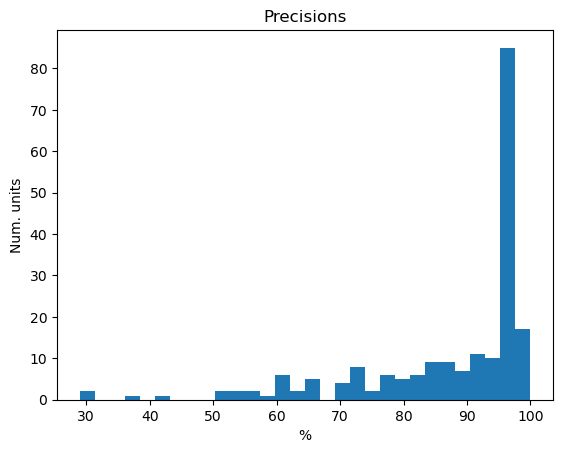

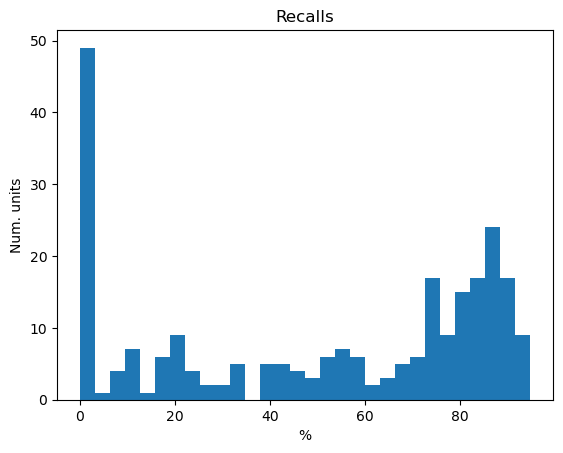

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 4.80 MB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/5b520368e2fa47be9c306cb35a633d6d



1
Setting variables


100%|██████████| 68074/68074 [03:12<00:00, 354.01it/s]


147.3575155477543


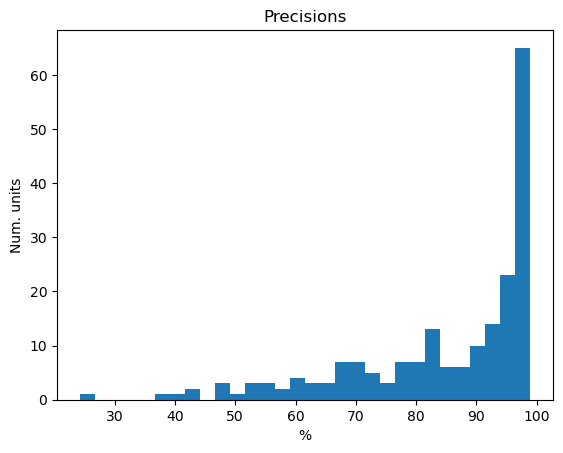

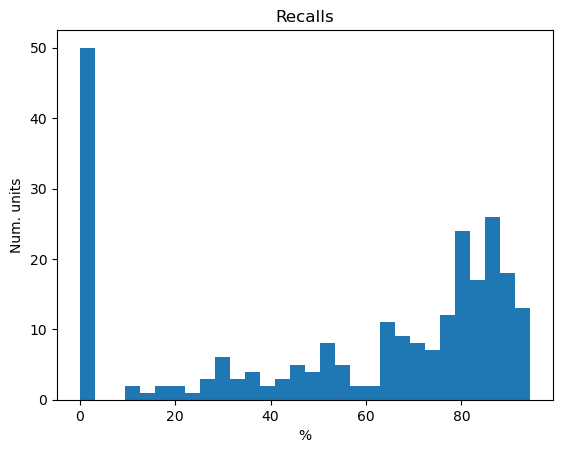

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/e224cf0e7a24478bbf80ce648bc16a76



2
Setting variables


100%|██████████| 68074/68074 [02:57<00:00, 383.94it/s]


143.3536272770264


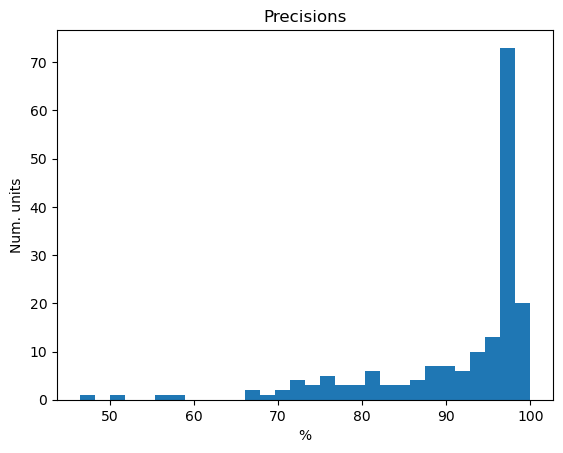

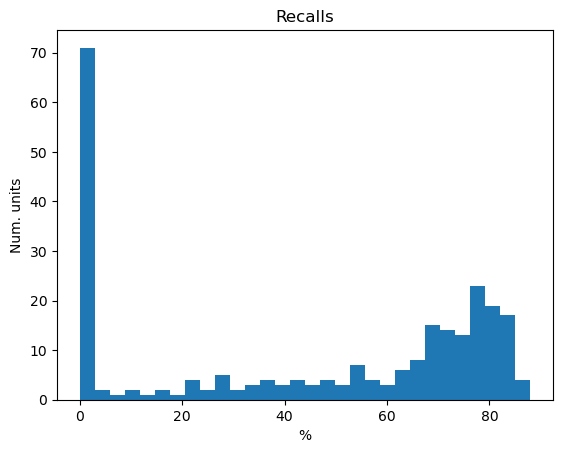

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/65744cd08a7e47fe8e0105dab9510f69



3
Setting variables


100%|██████████| 68074/68074 [03:29<00:00, 324.70it/s]


137.38893178082068


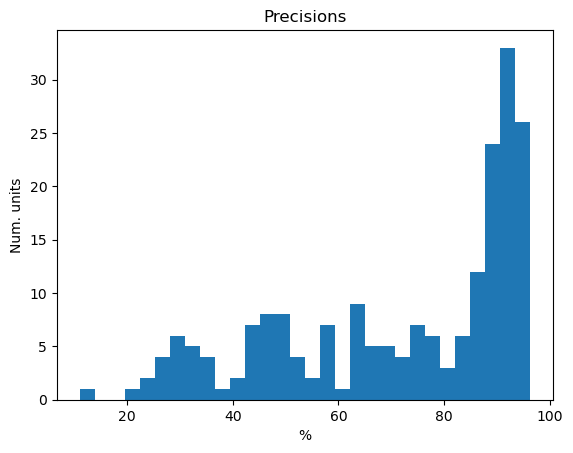

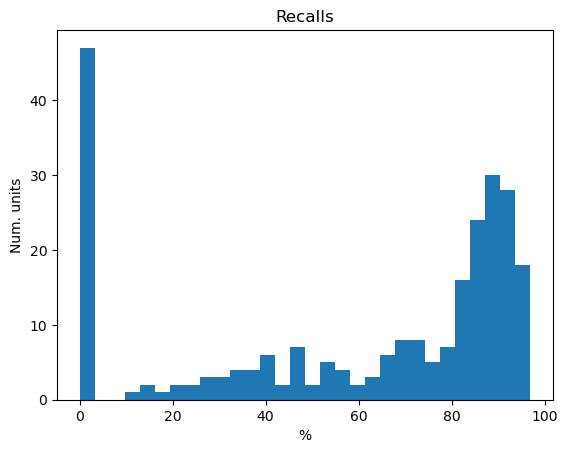

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/752b69ccd2a14d299a222fb6a334ef0b



4
Setting variables


100%|██████████| 68074/68074 [02:55<00:00, 387.70it/s]


144.79532861551644


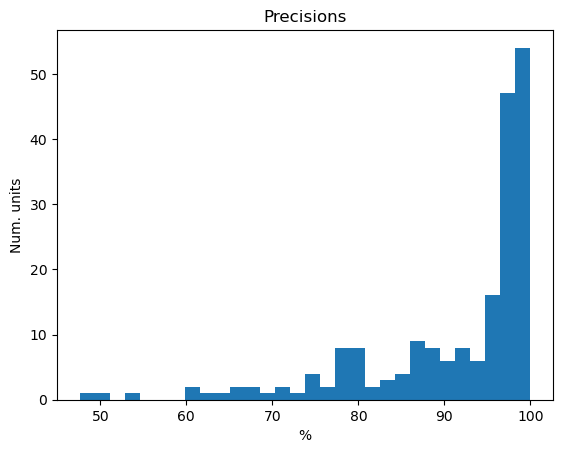

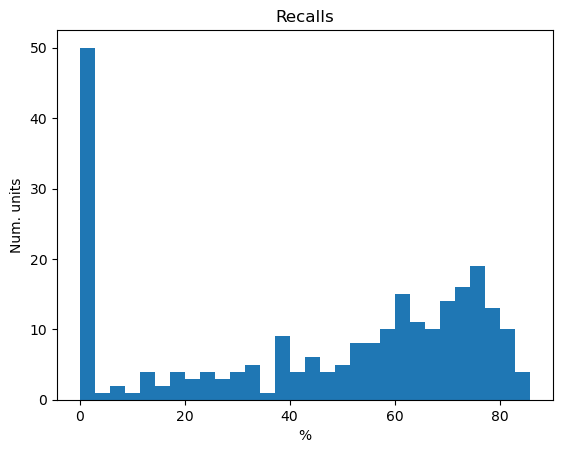

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 2 file(s), remaining 5.90 MB/6.97 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/48645dda8cd24b959fd7d6105c8ee5a6



5
Setting variables


100%|██████████| 68074/68074 [03:07<00:00, 363.86it/s]


146.95159546080453


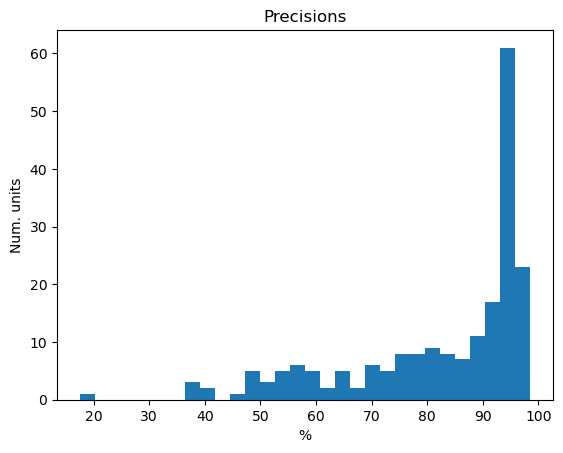

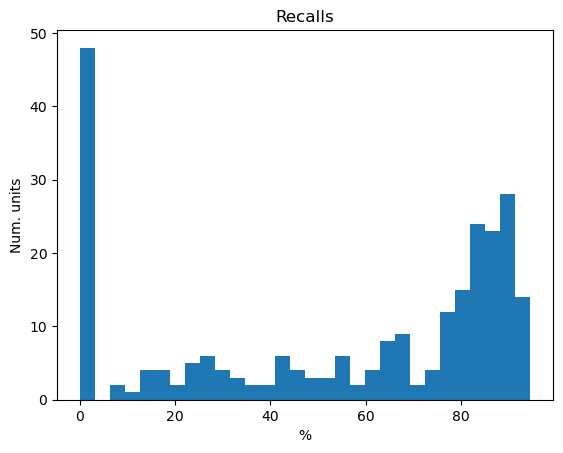

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/c0012a4e01924357aeeec4f737f7469b



6
Setting variables


100%|██████████| 68074/68074 [03:21<00:00, 337.42it/s]


137.25780340813102


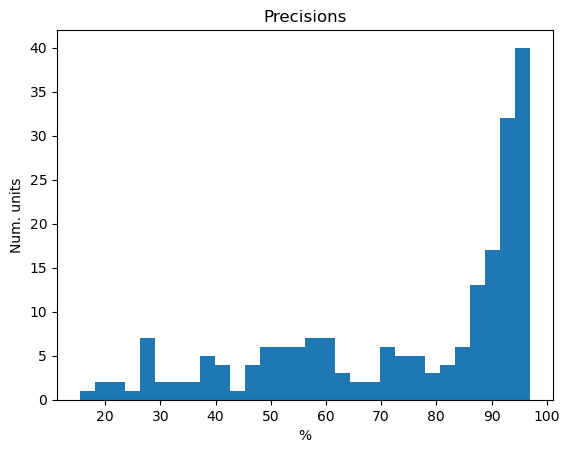

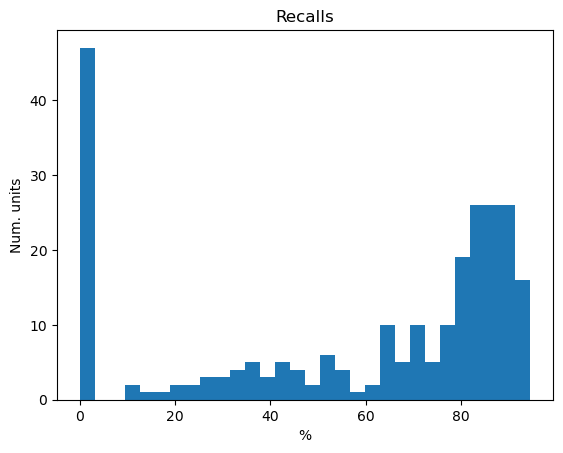

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 6 metrics, params and output messages
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/e46e777286a24fb3bc1319bae283e12b



7
Setting variables


100%|██████████| 68074/68074 [03:02<00:00, 372.20it/s]


139.77119937245737


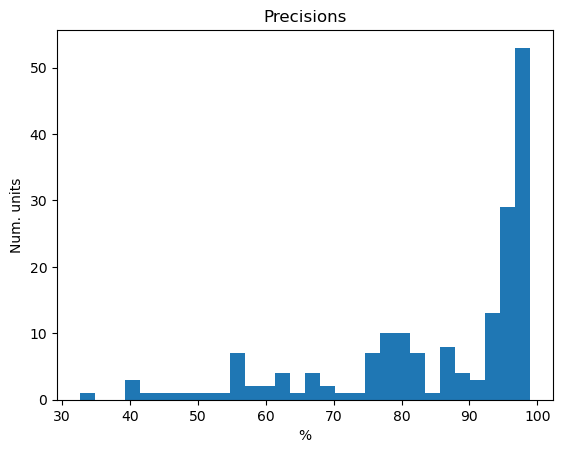

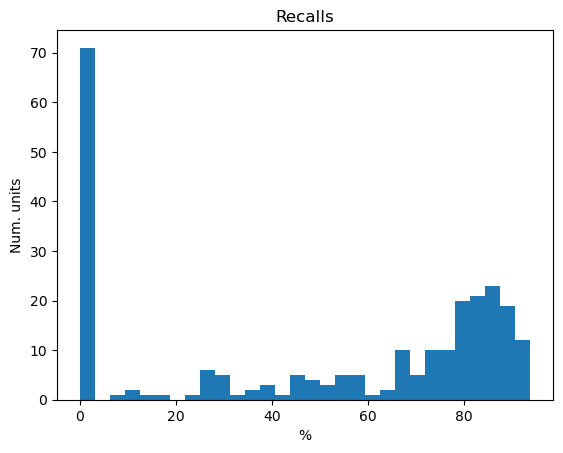

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/f4895606839546229bfcc51fa582a170



8
Setting variables


100%|██████████| 68074/68074 [02:55<00:00, 387.75it/s]


141.29834839763876


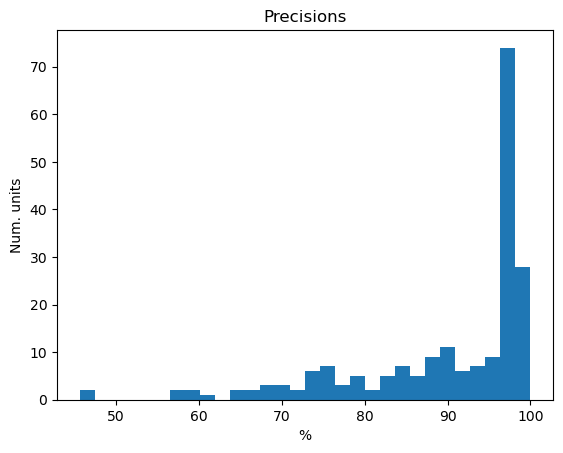

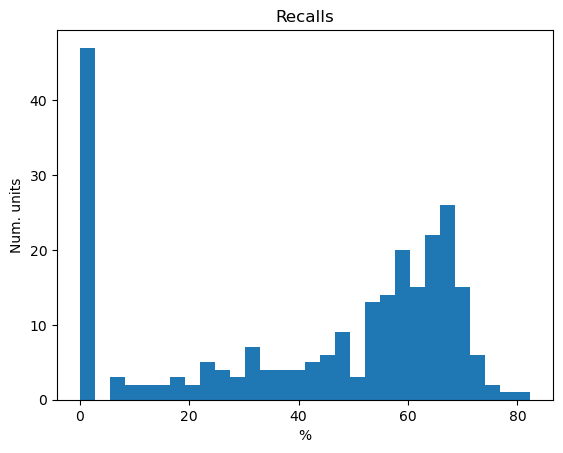

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 3.50 MB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/d99bf6586f1d43e49435e14a5ed8f814



9
Setting variables


100%|██████████| 68074/68074 [02:58<00:00, 381.03it/s]


146.406830476246


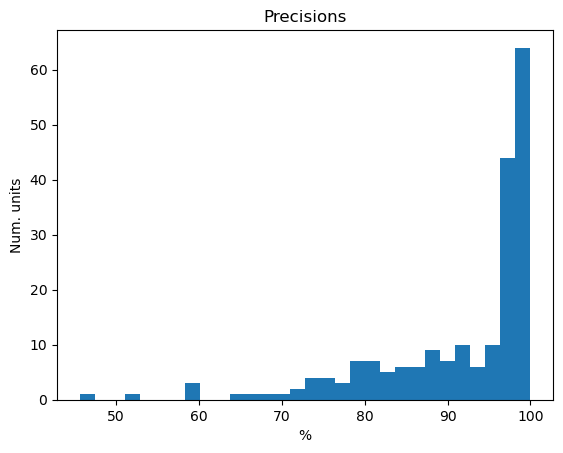

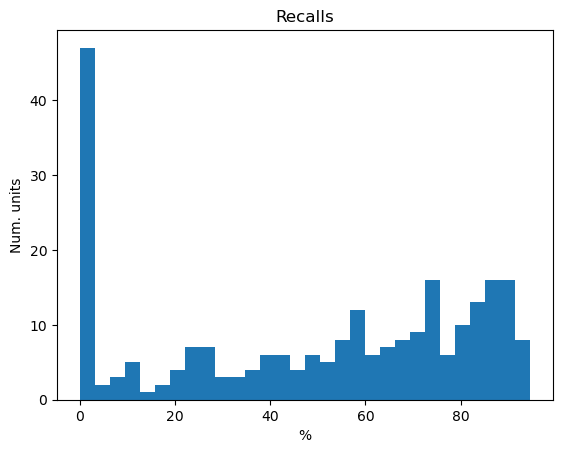

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/cec670e6c3d0470a980f468ca811272b



10
Setting variables


100%|██████████| 68074/68074 [03:01<00:00, 375.16it/s]


145.72486765711244


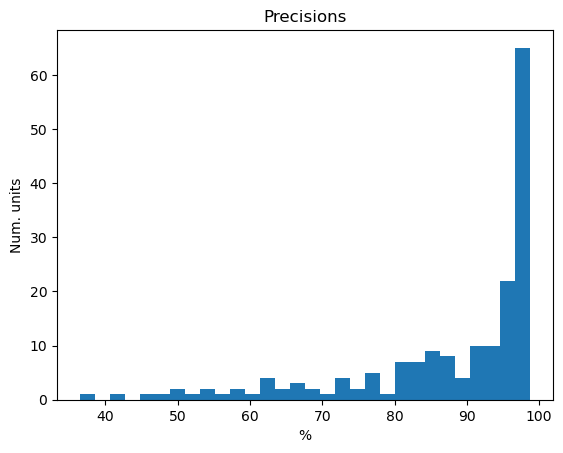

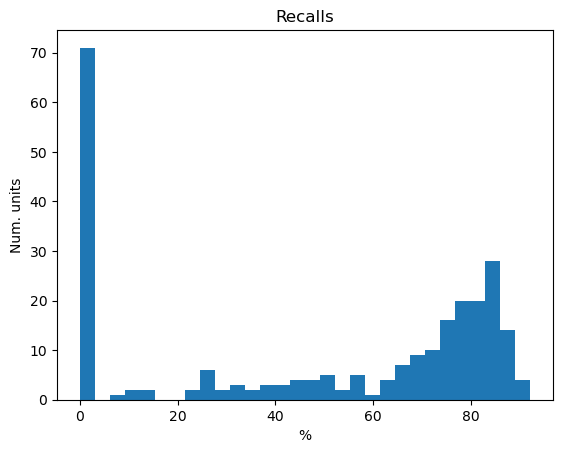

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/2355f7625f7e49ed89ddccc6065dec98



11
Setting variables


100%|██████████| 68074/68074 [03:35<00:00, 315.69it/s]


145.8511205419339


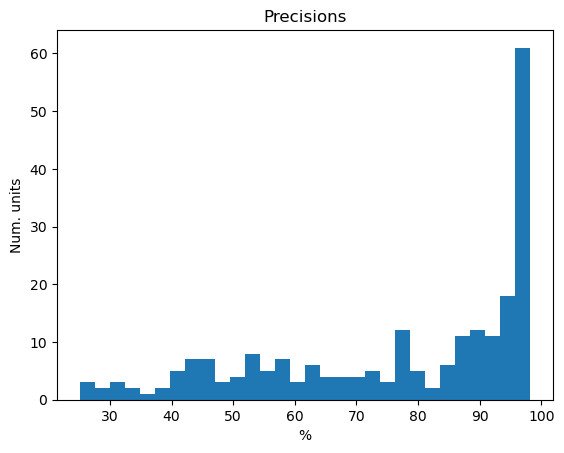

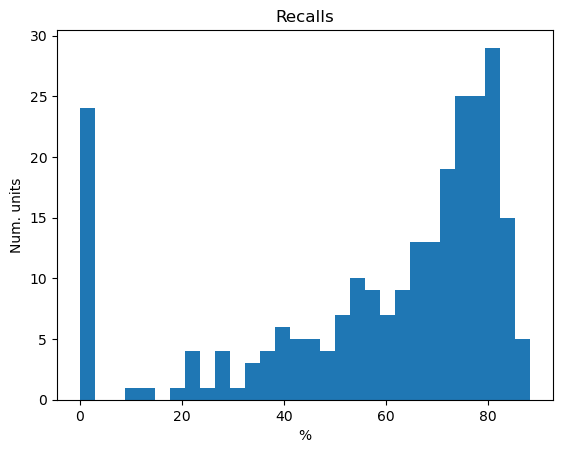

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: Still uploading 1 file(s), remaining 813.90 KB/6.92 MB
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/04af6b1740ae4d0a982e2f455da3163a



12
Setting variables


100%|██████████| 68074/68074 [03:17<00:00, 344.44it/s]


149.42281051670216


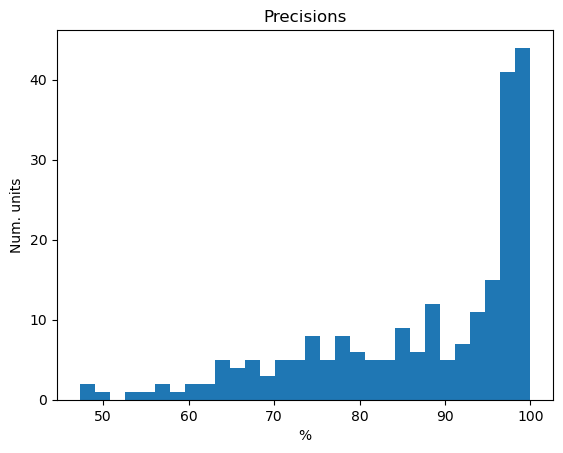

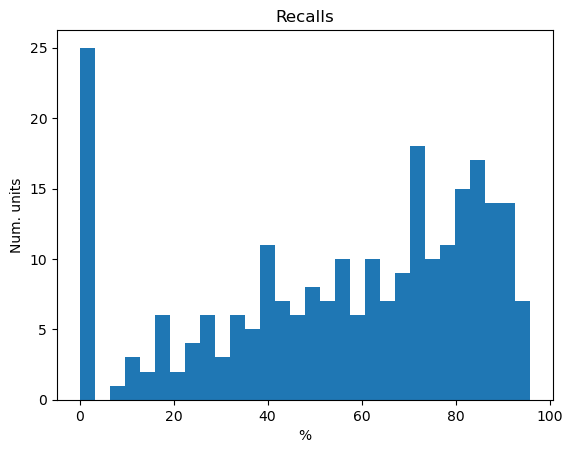

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/fb7557741c0f463cbe59d9aaca35870f



13
Setting variables


100%|██████████| 68074/68074 [03:40<00:00, 308.08it/s]


134.47759638825875


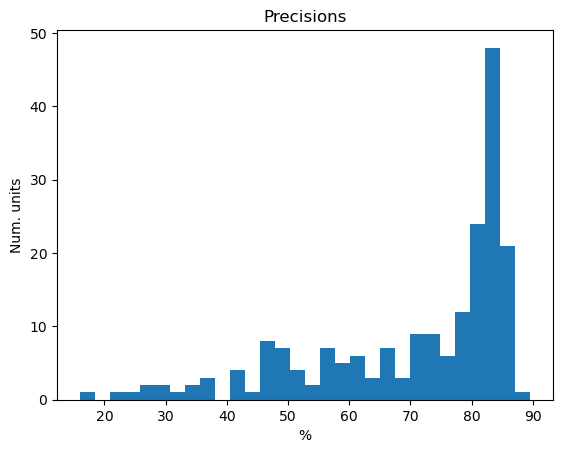

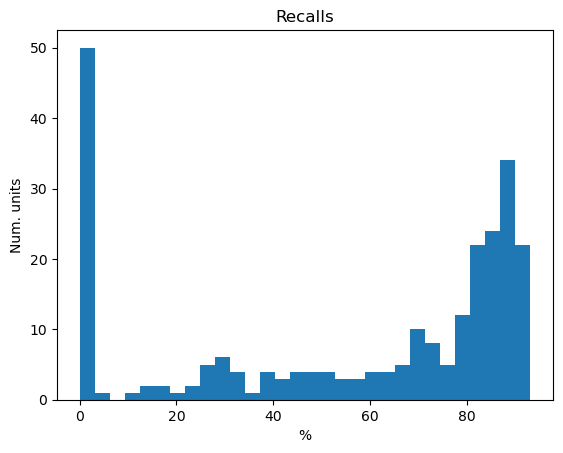

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for assets to finish uploading (timeout is 10800 seconds)
COMET INFO: All assets have been sent, waiting for delivery confirmation
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/max-workspace/si-sim-assign-spikes/c0aba5468c6a466196dd57de81dd05dd



14
Setting variables


 19%|█▉        | 12908/68074 [00:44<03:08, 293.09it/s]


KeyboardInterrupt: 

COMET INFO: Optimizer metrics is 'performance' but no logged values found. Experiment ignored in sweep.
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


In [49]:
EXPERIMENT_CONFIG = {
        "api_key": "max_api_key",
        "project_name": "si_sim_assign_spikes",
        "workspace": "max-workspace",

        "display_summary_level": 0,
    }

EXP_NAME_BASE = "SpikeTuning0.1_"

OPTIMIZER_CONFIG = {
        "algorithm": "bayes",
        "spec": {
            "maxCombo": 0,
            "metric": "performance",
            "objective": "maximize",},

        "parameters": {
            "MIN_LOOSE_DETECTIONS_N": {"type": "integer", "scaling_type": "uniform", "min": 2, "max": 5},
            "MIN_LOOSE_DETECTIONS_R": {"type": "float", "scaling_type": "uniform", "min": 0.33, "max": 0.5},
            "MIN_INNER_LOOSE_DETECTIONS": {"type": "integer", "scaling_type": "uniform", "min": 1, "max": 4},
            # "MIN_ELEC_PROB": {"type": "float", "scaling_type": "uniform", "min": 0.01, "max": 0.1},
            "MAX_LATENCY_DIFF_SPIKES": {"type": "float", "scaling_type": "uniform", "min": 3, "max": 6}, 
            "MAX_AMP_MEDIAN_DIFF_SPIKES": {"type": "float", "scaling_type": "uniform", "min": 0.3, "max": 0.7},  
            "MAX_ROOT_AMP_MEDIAN_STD": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 3},
            # "MAX_LATENCY_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 5},
            # "MAX_AMP_MEDIAN_DIFF_SEQUENCES": {"type": "float", "scaling_type": "uniform", "min": 0.1, "max": 0.5}
            "CLIP_LATENCY_DIFF": {"type": "float", "scaling_type": "uniform", "min": 4, "max": 10}, 
            "CLIP_AMP_DIFF": {"type": "float", "scaling_type": "uniform", "min": 1, "max": 2}, 
        }
    }

opt = comet_ml.Optimizer(config=OPTIMIZER_CONFIG)      
for i_exp, exp in enumerate(opt.get_experiments(**EXPERIMENT_CONFIG)):

    print(i_exp)
    print("Setting variables")
    
    MIN_LOOSE_DETECTIONS_N = exp.get_parameter("MIN_LOOSE_DETECTIONS_N")
    MIN_LOOSE_DETECTIONS_R = exp.get_parameter("MIN_LOOSE_DETECTIONS_R")
    MIN_INNER_LOOSE_DETECTIONS = exp.get_parameter("MIN_INNER_LOOSE_DETECTIONS")
    MAX_LATENCY_DIFF_SPIKES = exp.get_parameter("MAX_LATENCY_DIFF_SPIKES")
    MAX_AMP_MEDIAN_DIFF_SPIKES = exp.get_parameter("MAX_AMP_MEDIAN_DIFF_SPIKES")
    MAX_ROOT_AMP_MEDIAN_STD = exp.get_parameter("MAX_ROOT_AMP_MEDIAN_STD")
    
    CLIP_LATENCY_DIFF = exp.get_parameter("CLIP_LATENCY_DIFF") # 5 
    CLIP_AMP_DIFF = exp.get_parameter("CLIP_AMP_DIFF") # 1
    
    seqs_min_loose_elecs = [ceil(max(MIN_LOOSE_DETECTIONS_N, MIN_LOOSE_DETECTIONS_R * len(seq.loose_elecs))) for seq in all_sequences]
    seqs_min_loose_elecs = torch.tensor(seqs_min_loose_elecs, dtype=torch.int16, device="cuda")

    seq_detections = get_seq_detections()

    detected_spike_times = []
    for detections in seq_detections:
        detected_spike_times.append(np.sort([d.item() / SAMP_FREQ for d in detections]))
        
    gt_spike_times = []
    for seq in all_sequences:
        spike_train = seq.formation_spike_train
        gt_spike_times.append(np.sort(spike_train[spike_train >= PRE_MEDIAN_FRAMES/SAMP_FREQ]))

    precisions, recalls = [], []
    performances = []
    for detected, gt in zip(detected_spike_times, gt_spike_times):
        num_matches = Comparison.count_matching_events(detected, gt)
        if len(detected) > 0:
            precision = num_matches/len(detected) * 100
            precisions.append(precision)
        else:
            precision = 0
        recall = num_matches / len(gt) *100
        recalls.append(recall)
        performances.append(recall + precision)
    performance = np.median(performances)
    exp.log_metric("performance", performance)
    exp.set_name(EXP_NAME_BASE + f"{performance:.1f}")
    print(performance)
        
    plt.title("Precisions")
    plt.hist(precisions, bins=30)
    plt.ylabel("Num. units")
    plt.xlabel("%")
    plt.show()

    plt.title("Recalls")
    plt.hist(recalls, bins=30)
    plt.ylabel("Num. units")
    plt.xlabel("%")
    plt.show()
    
    exp.end()

In [19]:
detected_spike_times = []
for detections in seq_detections:
    detected_spike_times.append([d.item() / SAMP_FREQ for d in detections])
    
gt_spike_times = []
for seq in all_sequences:
    spike_train = seq.formation_spike_train
    gt_spike_times.append(spike_train[spike_train >= PRE_MEDIAN_FRAMES/SAMP_FREQ])

print(len(detected_spike_times))

250


In [36]:
precisions, recalls = [], []
for detected, gt in zip(detected_spike_times, gt_spike_times):
    num_matches = Comparison.count_matching_events(detected, gt)
    if len(detected) > 0:
        precisions.append(num_matches/len(detected) * 100)
    recalls.append(num_matches / len(gt) *100)

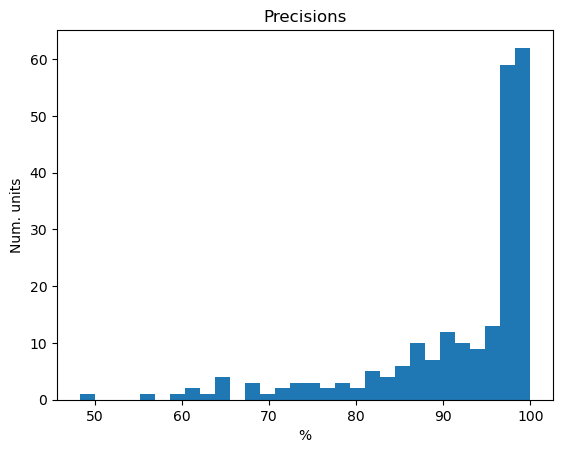

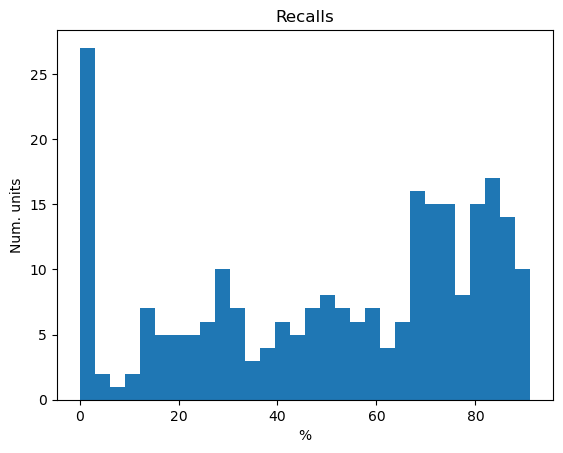

In [38]:
plt.title("Precisions")
plt.hist(precisions, bins=30)
plt.ylabel("Num. units")
plt.xlabel("%")
plt.show()

plt.title("Recalls")
plt.hist(recalls, bins=30)
plt.ylabel("Num. units")
plt.xlabel("%")
plt.show()

In [16]:

detected_sorter = DummySorter(detected_spike_times, name="RT-Sort")
gt_sorter = DummySorter(gt_spike_times, name="Ground-Truth")
comparison = Comparison(detected_sorter, gt_sorter)

ValueError: zero-dimensional arrays cannot be concatenated